#### Model taken from:
- [1] Offshore Pipelaying Dynamics. Gullik Anthon Jensen 
- [2] A nonlinear PDE formulation for offshore vessel pipeline installation. Gullik A. Jensen et al 
- [3] Modeling and Control of Offshore Pipelay Operations Based on a Finite Strain Pipe Model. Gullik A. Jensen 

In [1]:
# import julia;
# julia.install()

In [2]:
# pipe's mass is different from vessel's mass

In [3]:
import numpy as np
import numdifftools as nd
import math
import matplotlib.pyplot as plt
from datetime import datetime
# from scipy.integrate import odeint
# from torchdiffeq import odeint
import torch
import inspect
import random
from scipy.optimize import fsolve
from scipy.integrate import solve_ivp
import scipy
from numpy import linalg as LA

In [4]:
import sys
sys.path.insert(0, "../../../../Ocean_Intella/PythonVehicleSimulator-master/src/python_vehicle_simulator")
sys.path.insert(0, "../../../../Ocean_Intella/PythonVehicleSimulator-master/src")

In [5]:
# from diffeqpy import ode
# from diffeqpy import de

In [6]:
from vehicles import shipClarke83
from python_vehicle_simulator.vehicles import *
from python_vehicle_simulator.lib import *
from python_vehicle_simulator.lib.gnc import ssa

In [7]:
from sympy import *

In [8]:
def R2D(value):  # radians to degrees
    return value * 180 / math.pi

In [9]:
mp = 96 #  (submerged) [kg/m]

In [10]:
node_N = 4

In [11]:
mi = [mp for i in range(node_N)] 

In [12]:
# L - the hull length
# Xg - x-center of gravity
L = 169 # [m]
Xg = 78 # [m]
mn = 123000000 # mass of the vessel, [kg] !!!!!!!!!!!!!!!!!! Solitaire type vessel 

In [13]:
vessel_mass=mn/L # mass over length of vessel

In [14]:
diag_Irho = 1e2*np.array([1, 1, 2]) # [m^4]  , p.99 in [1]
 
Irho=np.diag(diag_Irho)

In [15]:
Irho

array([[100.,   0.,   0.],
       [  0., 100.,   0.],
       [  0.,   0., 200.]])

In [16]:
# Fossen book p.181
def vessel_inertia_moment(mn, Xg, L):
    r = 0.25*L
    Ir = mn*r**2
    Iz=mn*Xg**2 + Ir
    return Iz

In [17]:
vessel_inertia = vessel_inertia_moment(mn, Xg, L)

In [18]:
Irho+=vessel_inertia

In [19]:
vessel_inertia_coef = vessel_inertia/np.max(diag_Irho)

In [20]:
vessel_inertia_coef

4839473437.5

In [21]:
qw = 1025 # Water density [kg/m3]
d0 = 0.761 # Outer diameter of pipe, [m]

In [22]:
diag_DT = 1.5*np.array([1, 1, 1]) 
# diag_DT = 1.5e15*np.array([1, 1, 1]) # [N/m]  , p.99 in [1] !!!!!!!!!!!!!!!!!!!!!!!!!!!!

In [23]:
DT=np.diag(diag_DT) # (35) in [2]

In [24]:
DT

array([[1.5, 0. , 0. ],
       [0. , 1.5, 0. ],
       [0. , 0. , 1.5]])

In [25]:
diag_CT = 1e9*np.array([1, 1, 1]) # [Nm2] p. 4721 in [3]

In [26]:
CT=np.diag(diag_CT)

In [27]:
CT

array([[1.e+09, 0.e+00, 0.e+00],
       [0.e+00, 1.e+09, 0.e+00],
       [0.e+00, 0.e+00, 1.e+09]])

In [28]:
# angles should be in radians, otherwise np.radians them  
def Re_t_(arr):
    φ,θ,ψ=arr[0],arr[1],arr[2]
  
    Cφ=np.matrix([[1,0,0],
                      [0,np.cos(φ),-np.sin(φ)],
                      [0,np.sin(φ),np.cos(φ)]])

    Cθ=np.matrix([[np.cos(θ),0,np.sin(θ)],
                      [0,1,0],
                      [-np.sin(θ),0,np.cos(θ)]])

    Cψ=np.matrix([[np.cos(ψ),-np.sin(ψ),0],
                      [np.sin(ψ),np.cos(ψ),0],
                      [0,0,1]])
        

    return np.array(np.dot(np.dot(Cφ,Cθ),Cψ) )

In [29]:
Re_t_([1,2,3])

array([[ 0.41198225,  0.05872664,  0.90929743],
       [-0.68124272, -0.64287284,  0.35017549],
       [ 0.60512725, -0.76371834, -0.2248451 ]])

In [30]:
rng = np.random.default_rng()

In [31]:
φ, θ, ψ = rng.standard_normal(node_N),rng.standard_normal(node_N),rng.standard_normal(node_N)

In [32]:
def Re_t(a,b,c):
    xyz=np.stack((a,b,c), axis=1)
    return np.apply_along_axis(Re_t_, 1, xyz)

In [33]:
Re_t_(np.array([φ[0], θ[0], ψ[0]]))

array([[ 0.72175506,  0.55508794, -0.4134574 ],
       [-0.2523864 , -0.34515814, -0.90397288],
       [-0.64449263,  0.75679802, -0.10902299]])

In [34]:
startTime1 = datetime.now()
Ret=Re_t(φ,θ,ψ)
print(datetime.now() - startTime1)

0:00:00.000612


In [35]:
Ret

array([[[ 0.72175506,  0.55508794, -0.4134574 ],
        [-0.2523864 , -0.34515814, -0.90397288],
        [-0.64449263,  0.75679802, -0.10902299]],

       [[-0.04262597,  0.05639375,  0.99749826],
        [ 0.73428088, -0.67527309,  0.06955463],
        [ 0.67750617,  0.73540873, -0.01262468]],

       [[ 0.84236338, -0.3878521 , -0.37415864],
        [ 0.23985837,  0.89155687, -0.38418006],
        [ 0.48258874,  0.23387413,  0.84404443]],

       [[ 0.96647904, -0.24019925,  0.09067847],
        [ 0.24791982,  0.78130442, -0.57279941],
        [ 0.06673851,  0.57607961,  0.8146645 ]]])

In [36]:
Ret.shape

(4, 3, 3)

In [37]:
dx,dy,dz=rng.standard_normal(node_N),rng.standard_normal(node_N),rng.standard_normal(node_N)

In [38]:
def C1(dx,dy,dz, Ret):
    B=np.vstack([np.abs(dx)*dx,(dy**2+dz**2)**0.5*dy,(dy**2+dz**2)**0.5*dz])
#     print(np.dot(Ret[0],B.T[0]))
    ans=np.einsum('ijk,ik->ij', Ret, np.einsum('ijk,ik->ij', Ret,B.T.astype(np.float32))) 
    return ans.T

In [39]:
np.abs(dx)*dx

array([-0.11258721,  0.32593189,  1.0627384 , -0.36163486])

In [40]:
C1(dx,dy,dz,Ret)

array([[-0.10829886,  0.33169958,  1.93680802, -0.30618595],
       [-0.04805899, -0.1167538 ,  0.3730563 , -0.12349382],
       [ 0.03251964,  0.06244761,  0.15212361, -0.16516479]])

In [41]:
C1(dx,dy,dz,Ret).shape

(3, 4)

In [42]:
startTime1 = datetime.now()
C1(dx,dy,dz,Ret)
print(datetime.now() - startTime1)

0:00:00.000493


In [43]:
def fD(dx,dy,dz,DT,Ret):
    return 1/2*d0*qw*np.dot(DT, C1(dx,dy,dz,Ret))*9.81

In [44]:
1/2*d0*qw*np.dot(DT,C1(dx,dy,dz,Ret).T[0])*9.81

array([-621.53085572, -275.81217924,  186.63129799])

In [45]:
fD(dx,dy,dz,DT,Ret)

array([[ -621.53085572,  1903.63512766, 11115.40693508, -1757.21158491],
       [ -275.81217924,  -670.05404253,  2140.98275228,  -708.73520035],
       [  186.63129799,   358.38892593,   873.04256958,  -947.8863599 ]])

In [46]:
fD(dx,dy,dz,DT,Ret).T

array([[ -621.53085572,  -275.81217924,   186.63129799],
       [ 1903.63512766,  -670.05404253,   358.38892593],
       [11115.40693508,  2140.98275228,   873.04256958],
       [-1757.21158491,  -708.73520035,  -947.8863599 ]])

In [47]:
startTime1 = datetime.now()
fD(dx,dy,dz,DT,Ret)
print(datetime.now() - startTime1)

0:00:00.000248


In [48]:
# https://docs.scipy.org/doc/scipy-1.8.0/tutorial/integrate.html  
# 1-D Gray-Scott 

In [49]:
I=np.identity(3)

In [50]:
startTime1 = datetime.now()
np.dot(I,fD(dx,dy,dz,DT,Ret))
print(datetime.now() - startTime1)

0:00:00.000488


In [51]:
Rb_t=I # https://www.researchgate.net/profile/Thor-Fossen/publication/224560837_Modeling_and_Control_of_Offshore_Pipelay_Operations_Based_on_a_Finite_Strain_Pipe_Model/links/00b7d520e175a3f918000000/Modeling-and-Control-of-Offshore-Pipelay-Operations-Based-on-a-Finite-Strain-Pipe-Model.pdf

In [52]:
Rb_t

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

In [53]:
diag_DR = 1.5*np.array([1, 1, 1]) # [N m/rad]  p.4721 in [3]

In [54]:
DR=np.diag(diag_DR) 

In [55]:
dI= 0.69# Inner diameter of pipe, [m]

In [56]:
Ar=math.pi*((d0/2)**2-(dI/2)**2)

In [57]:
Ar

0.08091250419136858

In [58]:
fg_e=np.array([[0,0,(mp-qw*Ar)*9.81] for x in range(node_N)])

In [59]:
fg_e

array([[  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223]])

In [60]:
# # not checked 
# def k_sigma(hi,d0,fg_e):
#     ans=[]
#     for it in hi:
#         if it<0:
#             ans.append(0)
#         elif 0<=it<=d0/20:
#             ans.append(np.float32(LA.norm(fg_e,2)/(d0/8-d0/40)*10*it**2/d0))
#         else:
#             ans.append(np.float32(LA.norm(fg_e,2)/(d0/8-d0/40)*(it-d0/40)))     
#     return np.array(ans).reshape(node_N,1)   

In [61]:
x,y,z=100*rng.standard_normal(node_N),100*rng.standard_normal(node_N),100*rng.standard_normal(node_N)

In [62]:
# # not checked
# def hi(x,y,z,d0):
#     return (np.dot(np.array([x,y,z]).T,[0,0,1])+d0/2).reshape(node_N,1) 

In [63]:
# startTime1 = datetime.now()
# hi(x,y,z,d0)
# print(datetime.now() - startTime1)

In [64]:
# k_sigma(hi(x,y,z,d0),d0,fg_e)

In [65]:
# startTime1 = datetime.now()
# k_sigma(hi(x,y,z,d0),d0,fg_e)
# print(datetime.now() - startTime1)

In [66]:
# # TODO: force shoud be acting only at nodes that are in contact with the seabed
# # not checked
# def sigma(x,y,z):
#     return (k_sigma(hi(x,y,z,d0),d0,fg_e)*np.array([0,0,1]))

In [67]:
# startTime1 = datetime.now()
# sigma(x,y,z)
# print(datetime.now() - startTime1)

In [68]:
def Re_b(Ret):
#     return np.dot(Ret, Rb_t ) # (5) in[3]
    return Ret

In [69]:
startTime1 = datetime.now()
Re_b(Ret)
print(datetime.now() - startTime1)

0:00:00.000111


In [70]:
def phi(x, y, z, Ret,dummy):
    B=np.vstack([x,y,z])
    return np.einsum('ijk,ik->ij', Ret,B.T.astype(np.float32))

In [71]:
phi(x,y,z,Ret,None)

array([[-156.6741545 ,   97.65065212,  131.35663958],
       [-125.38938485,  161.55796198, -122.73304284],
       [ 122.05515962, -197.82723522,   65.23375187],
       [ -12.55879513,  -23.84023791, -207.02119405]])

In [72]:
# def d_s(da,db,dc,x,y,z):

#     ds=np.sqrt(np.diff(x,prepend=x[0])**2+np.diff(y,prepend=y[0])**2
#                  +np.diff(z,prepend=z[0])**2)
#     ds[ds == 0] = 1
#     return np.vstack([np.diff(da,prepend=da[0])/ds,np.diff(db,prepend=db[0])/ds,np.diff(dc,prepend=dc[0])/ds])

In [73]:
startTime1 = datetime.now()
phi(x,y,z,Ret,None)
print(datetime.now() - startTime1)

0:00:00.000162


In [74]:
def Π_(arr):
    φ,θ,ψ=arr[0],arr[1],arr[2]
    return np.array([[np.cos(θ),0,np.cos(φ)*np.sin(θ)],
                  [0,1,-np.sin(φ)],
                  [-np.sin(θ),0,np.cos(φ)*np.cos(θ)]])

In [75]:
def Π(a,b,c):
    xyz=np.stack((a,b,c), axis=1)
  
    return np.apply_along_axis(Π_, 1, xyz)
    

In [76]:
startTime1 = datetime.now()
Π(φ,θ,ψ).shape
print(datetime.now() - startTime1)

0:00:00.000380


In [77]:
def ωe(φ,θ,ψ, dummy,dummy1):  # (100) in [2]
    A=Π(φ,θ,ψ)
    B=np.vstack([φ,θ,ψ])
    return np.einsum('ijk,ik->ij',A,B.T.astype(np.float32))

In [78]:
startTime1 = datetime.now()
ωe(φ,θ,ψ,None,None)
print(datetime.now() - startTime1)

0:00:00.000484


In [79]:
ωe(φ,θ,ψ,None,None)

array([[ 1.50707594,  0.22463683,  0.77055805],
       [ 0.06617571,  0.73284054, -1.39942273],
       [ 0.24917332, -0.56224561,  0.52402066],
       [ 0.6283555 , -0.04930501,  0.14287936]])

In [80]:
def d_s(f,a,b,c,Ret,omega):

    fun = f(a,b,c,Ret,omega)    
    
    def S(arr):
        a1,a2,a3=arr[0],arr[1],arr[2]
        return np.array([[0, -a3, a2 ],
                         [a3, 0, -a1],
                        [-a2, a1, 0]])
    
    K=np.apply_along_axis(S, 1, omega)
#     print('fun',fun)
#     print('K',K)
#     print('ans',np.einsum('ijk,ik->ij',K,fun).T)

    return np.einsum('ijk,ik->ij',K,fun.astype(np.float32)).T



In [81]:
d_s(phi,x,y,z,Ret,ωe(φ,θ,ψ,None,None))

array([[ -45.73795442,  136.1441453 ,   66.98817162,   13.61346094],
       [-318.6909636 ,  183.59469569,   47.7049162 ,  128.28851302],
       [ 182.36172924,  102.58163451,   19.33170908,  -15.59935653]])

In [82]:
# def d_s(f,a,b,c,Ret):
# #     ds=np.sqrt(np.diff(a,prepend=a[0])**2+np.diff(b,prepend=b[0])**2
# #                  +np.diff(c,prepend=c[0])**2)
#     ds=np.sqrt(np.diff(a)**2+np.diff(b)**2+np.diff(c)**2)
#     ds[ds == 0] = 1
#     fun = f(a,b,c,Ret)
#     ans=(np.diff(fun,axis=0) / ds.reshape(node_N-1,1)).T
#     return np.insert(ans, -1, 0.8*ans[:,-1], axis=1)

In [83]:
# def d_s(f,a,c,Ret):
# #     ds=np.sqrt(np.diff(a,prepend=a[0])**2+np.diff(c,prepend=c[0])**2)
#     ds=np.sqrt(np.diff(a)**2+np.diff(c)**2)
# #     ds[ds == 0] = 1
#     fun = f(a,c,Ret)
# #     ans=(np.diff(fun,prepend=fun[0].reshape(1,2),axis=0) / ds.reshape(node_N,1)).T
#     ans=(np.diff(fun,axis=0) / ds.reshape(node_N-1,1)).T
#     np.insert(ans, -1, ans[:,-1], axis=1)
#     return np.insert(ans, -1, 1.1*ans[:,-1], axis=1)

In [84]:
# d_s(phi,x,y,z,Ret)

In [85]:
startTime1 = datetime.now()
d_s(phi,x,y,z,Ret,ωe(φ,θ,ψ,None,None))
print(datetime.now() - startTime1)

0:00:00.003153


In [86]:
def ne(x,y,z,Ret,omega):
    A=np.multiply(np.multiply(Ret,CT),Ret)
    B=d_s(phi,x,y,z,Ret,omega).T
    return np.einsum('ijk,ik->ij', A.astype(np.float32),B-
                     np.einsum('ijk,kp->ijp',Ret.astype(np.float32), np.array([1,0,0]).reshape(3,1)).squeeze())

In [87]:
def ne_(dx,dy,dz,DT,Ret):
    return -fg_e.T-fD(dx,dy,dz,DT,Ret) #-sigma(x,y,z).T

In [88]:
# sigma(x,y,z)

In [89]:
ne_(dx,dy,dz,DT,Ret)

array([[   621.53085572,  -1903.63512766, -11115.40693508,
          1757.21158491],
       [   275.81217924,    670.05404253,  -2140.98275228,
           708.73520035],
       [  -314.79584022,   -486.55346816,  -1001.20711181,
           819.72181767]])

In [90]:
# mp*ddp = d_s(ne,ds)+np.dot(Re_b,ne_)

In [91]:
startTime1 = datetime.now()
ne(x,y,z,Ret,ωe(φ,θ,ψ,None,None))
print(datetime.now() - startTime1)

0:00:00.001008


In [92]:
ne(x,y,z,Ret,ωe(φ,θ,ψ,None,None))

array([[-2.42022735e+10, -3.79369073e+10,  2.17521397e+09],
       [ 2.47447754e+08,  8.33832023e+10,  1.62417427e+07],
       [ 4.69354823e+10,  3.77287244e+10,  1.34283208e+10],
       [ 1.18133147e+10,  7.81606654e+10, -1.03972469e+10]])

In [93]:
startTime1 = datetime.now()
ne_(dx,dy,dz,DT,Ret)
print(datetime.now() - startTime1)

0:00:00.000768


In [94]:
Re_b(Ret).shape

(4, 3, 3)

In [95]:
def Irho_e(Ret):
    ans= np.multiply(np.multiply(Ret,Irho),Ret) # (19) in [3] 
    return ans
#     tmp=[1 for i in range(node_N)]
#     tmp[-1]=1e13
#     print(ans)
#     return ans*np.array(tmp).reshape(node_N,1)
#     return np.einsum("ijk,ip->ijk", ans, np.array(tmp).reshape(node_N,1))

In [96]:
Irho_e(Ret)

array([[[5.04205729e+11, 2.98230243e+11, 1.65458716e+11],
        [6.16538217e+10, 1.15309302e+11, 7.90931564e+11],
        [4.02035137e+11, 5.54355143e+11, 1.15044074e+10]],

       [[1.75863900e+09, 3.07815204e+09, 9.63057896e+11],
        [5.21858242e+11, 4.41353920e+11, 4.68252549e+09],
        [4.44277806e+11, 5.23462615e+11, 1.54265547e+08]],

       [[6.86794903e+11, 1.45599670e+11, 1.35500114e+11],
        [5.56849557e+10, 7.69353978e+11, 1.42855754e+11],
        [2.25414829e+11, 5.29410401e+10, 6.89538819e+11]],

       [[9.04092748e+11, 5.58433439e+10, 7.95859553e+09],
        [5.94909093e+10, 5.90838338e+11, 3.17565440e+11],
        [4.31103016e+09, 3.21213005e+11, 6.42370652e+11]]])

In [97]:
startTime1 = datetime.now()
Irho_e(Ret)
print(datetime.now() - startTime1)

0:00:00.000106


In [98]:
# def Π_(arr):
#     φ,θ,ψ=arr[0],arr[1],arr[2]
#     return np.array([[np.cos(θ),0,np.cos(φ)*np.sin(θ)],
#                   [0,1,-np.sin(φ)],
#                   [-np.sin(θ),0,np.cos(φ)*np.cos(θ)]])

In [99]:
# def Π(a,b,c):
#     xyz=np.stack((a,b,c), axis=1)
  
#     return np.apply_along_axis(Π_, 1, xyz)
    

In [100]:
# startTime1 = datetime.now()
# Π(φ,θ,ψ).shape
# print(datetime.now() - startTime1)

In [101]:
# def ωe(φ,θ,ψ, dummy):  # (100) in [2]
#     A=Π(φ,θ,ψ)
#     B=np.vstack([φ,θ,ψ])
#     return np.einsum('ijk,ik->ij',A,B.T)

In [102]:
# startTime1 = datetime.now()
# ωe(φ,θ,ψ,None)
# print(datetime.now() - startTime1)

In [103]:
# ωe(φ,θ,ψ,None)

In [104]:
diag_CR = 1e11*np.array([1, 1, 1]) 
CR=np.diag(diag_CR)

In [105]:
CR

array([[1.e+11, 0.e+00, 0.e+00],
       [0.e+00, 1.e+11, 0.e+00],
       [0.e+00, 0.e+00, 1.e+11]])

In [106]:
def d_me(φ,θ,ψ,Ret,fun,omega):
    A=np.multiply(np.multiply(Ret,CR),Ret)
    B=d_s(fun,φ,θ,ψ,None,omega.astype(np.float32))
 
    return np.einsum('ijk,ik->ij', A,B.T.astype(np.float32)) 

In [107]:
startTime1 = datetime.now()
d_me_=d_me(φ,θ,ψ,Ret,ωe, ωe(φ,θ,ψ,None,None))
print(datetime.now() - startTime1)

0:00:00.001554


In [108]:
d_me_

array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]])

In [109]:
diag_DR = 1.5*np.array([1, 1, 1]) 
 
DR=np.diag(diag_DR)

In [110]:
# np.dot(Re_b, np.dot( Irho_e, (np.dot(Π(φ,θ,ψ), np.array([ddφ,ddθ,ddψ])))))=
# -np.dot(Re_b,np.dot(Irho_e,np.dot(Π(dφ,dθ,dψ),np.array([dφ,dθ,dψ])))-
# np.cross(np.dot(Π(φ,θ,ψ),np.array([dφ,dθ,dψ])),np.dot(Irho_e, np.dot(Π(φ,θ,ψ),np.array([dφ,dθ,dψ]))))+
# np.dot(Re_b,d_s(me_[0],me_[1],me_[2],dt,ds)+d_s(me_[0],me_[1],me_[2],dt,ds))+
# np.cross(d_s(x,y,z,dt,ds),ne(x,y,z,φ,θ,ψ,dt,ds))+
# np.dot(Re_b,-np.dot(DR,np.dot(Π(φ,θ,ψ),np.array([dφ,dθ,dψ]))))

In [111]:
ne_(dx,dy,dz,DT,Ret)

array([[   621.53085572,  -1903.63512766, -11115.40693508,
          1757.21158491],
       [   275.81217924,    670.05404253,  -2140.98275228,
           708.73520035],
       [  -314.79584022,   -486.55346816,  -1001.20711181,
           819.72181767]])

In [112]:
C=ne(x,y,z,Ret,ωe(φ,θ,ψ,None,None))
  
a,b,c=C[:,0],C[:,1],C[:,2]

In [113]:
Re_b(Ret).shape

(4, 3, 3)

In [114]:
ne_(dx,dy,dz,DT, Ret).T

array([[   621.53085572,    275.81217924,   -314.79584022],
       [ -1903.63512766,    670.05404253,   -486.55346816],
       [-11115.40693508,  -2140.98275228,  -1001.20711181],
       [  1757.21158491,    708.73520035,    819.72181767]])

In [115]:
type(x),y,z,dx,type(dy),dz

(numpy.ndarray,
 array([ -21.26240456, -206.42587821, -208.45709175, -134.87056144]),
 array([ -37.81634421, -112.28912535,   85.39347153, -156.13595605]),
 array([-0.33554018,  0.57090445,  1.03089204, -0.60136084]),
 numpy.ndarray,
 array([ 0.19764665, -0.13477408, -0.88910942, -0.13798129]))

In [116]:
ne_(dx,dy,dz,DT,Ret).T+np.einsum('ijk,ik->ij', Re_b(Ret),ne_(dx,dy,dz,DT,Ret).T.astype(np.float32))

array([[  1353.37858746,    308.31432338,   -472.31382936],
       [ -2270.04020503,  -1214.06032769,  -1277.37186382],
       [-19273.62404397,  -6331.27025749,  -7711.16124415],
       [  3359.61315581,   1228.58457444,   2013.08166094]])

In [117]:
ne_(dx,dy,dz,DT,Ret).T

array([[   621.53085572,    275.81217924,   -314.79584022],
       [ -1903.63512766,    670.05404253,   -486.55346816],
       [-11115.40693508,  -2140.98275228,  -1001.20711181],
       [  1757.21158491,    708.73520035,    819.72181767]])

### Vessel

In [118]:
class VesselSemisub: # Semisub model from Fossen
    
    def __init__(self):
        
        MRB = 1.0e10 * np.array(
            [
                [0.0027, 0, 0, 0, -0.0530, 0],
                [0, 0.0027, 0, 0.0530, 0, -0.0014],
                [0, 0, 0.0027, 0, 0.0014, 0],
                [0, 0.0530, 0, 3.4775, 0, -0.0265],
                [-0.0530, 0, 0.0014, 0, 3.8150, 0],
                [0, -0.0014, 0, -0.0265, 0, 3.7192],
            ],
            float,
        )

        MA = 1.0e10 * np.array(
            [
                [0.0017, 0, 0, 0, -0.0255, 0],
                [0, 0.0042, 0, 0.0365, 0, 0],
                [0, 0, 0.0021, 0, 0, 0],
                [0, 0.0365, 0, 1.3416, 0, 0],
                [-0.0255, 0, 0, 0, 2.2267, 0],
                [0, 0, 0, 0, 0, 3.2049],
            ],
            float,
        )

        self.D = 1.0e09 * np.array(
            [
                [0.0004, 0, 0, 0, -0.0085, 0],
                [0, 0.0003, 0, 0.0067, 0, -0.0002],
                [0, 0, 0.0034, 0, 0.0017, 0],
                [0, 0.0067, 0, 4.8841, 0, -0.0034],
                [-0.0085, 0, 0.0017, 0, 7.1383, 0],
                [0, -0.0002, 0, -0.0034, 0, 0.8656],
            ],
            float,
        )

        self.G = 1.0e10 * np.diag([0.0, 0.0, 0.0006, 1.4296, 2.6212, 0.0])
        self.M = MRB + MA

    def eq_left(self,η, dη):
        return (np.matmul(self.D, dη) + np.dot(self.G,η))
        
    def tau(self,η, dη, ddη):
        return (np.matmul(self.M,ddη) + np.matmul(self.D, dη) + np.dot(self.G,η))

In [119]:
V=VesselSemisub()

In [120]:
η=np.array([0.1,0.3,0.4,0.5,0.6,0.7])
dη=np.array([0,0,0,0,0,0])
ddη=np.array([0,0,0,0,0,0])

In [121]:
tau_force = V.tau(η,dη, ddη)

In [122]:
tau_force

array([0.00000e+00, 0.00000e+00, 2.40000e+06, 7.14800e+09, 1.57272e+10,
       0.00000e+00])

In [123]:
class VesselOtter: 
    
    def __init__(
        self, 
        controlSystem="stepInput", 
        r = 0, 
        V_current = 0, 
        beta_current = 0,
        tau_X = 120
    ):
        
        # Constants
        D2R = math.pi / 180     # deg2rad
        self.g = 9.81           # acceleration of gravity (m/s^2)
        rho = 1026              # density of water (kg/m^3)

        if controlSystem == "headingAutopilot":
            self.controlDescription = (
                "Heading autopilot, psi_d = "
                + str(r)
                + " deg"
                )
        else:
            self.controlDescription = "Step inputs for n1 and n2"
            controlSystem = "stepInput"

        self.ref = r
        self.V_c = V_current
        self.beta_c = beta_current * D2R
        self.controlMode = controlSystem
        self.tauX = tau_X  # surge force (N)

        # Initialize the Otter USV model
        self.T_n = 1.0  # propeller time constants (s)
        self.L = 2.0    # Length (m)
        self.B = 1.08   # beam (m)
        self.nu = np.array([0, 0, 0, 0, 0, 0], float)  # velocity vector
        self.u_actual = np.array([0, 0], float)  # propeller revolution states
        self.name = "Otter USV (see 'otter.py' for more details)"

        self.controls = [
            "Left propeller shaft speed (rad/s)",
            "Right propeller shaft speed (rad/s)"
        ]
        self.dimU = len(self.controls)

        # Vehicle parameters
        m = 55.0                                 # mass (kg)
        self.mp = 25.0                           # Payload (kg)
        self.m_total = m + self.mp
        self.rp = np.array([0.05, 0, -0.35], float) # location of payload (m)
        rg = np.array([0.2, 0, -0.2], float)     # CG for hull only (m)
        rg = (m * rg + self.mp * self.rp) / (m + self.mp)  # CG corrected for payload
        self.S_rg = Smtrx(rg)
        self.H_rg = Hmtrx(rg)
        self.S_rp = Smtrx(self.rp)

        R44 = 0.4 * self.B  # radii of gyration (m)
        R55 = 0.25 * self.L
        R66 = 0.25 * self.L
        T_yaw = 1.0         # time constant in yaw (s)
        Umax = 6 * 0.5144   # max forward speed (m/s)

        # Data for one pontoon
        self.B_pont = 0.25  # beam of one pontoon (m)
        y_pont = 0.395      # distance from centerline to waterline centroid (m)
        Cw_pont = 0.75      # waterline area coefficient (-)
        Cb_pont = 0.4       # block coefficient, computed from m = 55 kg

        # Inertia dyadic, volume displacement and draft
        nabla = (m + self.mp) / rho  # volume
        self.T = nabla / (2 * Cb_pont * self.B_pont * self.L)  # draft
        Ig_CG = m * np.diag(np.array([R44 ** 2, R55 ** 2, R66 ** 2]))
        self.Ig = Ig_CG - m * self.S_rg @ self.S_rg - self.mp * self.S_rp @ self.S_rp

        # Experimental propeller data including lever arms
        self.l1 = -y_pont  # lever arm, left propeller (m)
        self.l2 = y_pont  # lever arm, right propeller (m)
        self.k_pos = 0.02216 / 2  # Positive Bollard, one propeller
        self.k_neg = 0.01289 / 2  # Negative Bollard, one propeller
        self.n_max = math.sqrt((0.5 * 24.4 * self.g) / self.k_pos)  # max. prop. rev.
        self.n_min = -math.sqrt((0.5 * 13.6 * self.g) / self.k_neg) # min. prop. rev.

        # MRB_CG = [ (m+mp) * I3  O3      (Fossen 2021, Chapter 3)
        #               O3       Ig ]
        MRB_CG = np.zeros((6, 6))
        MRB_CG[0:3, 0:3] = (m + self.mp) * np.identity(3)
        MRB_CG[3:6, 3:6] = self.Ig
        MRB = self.H_rg.T @ MRB_CG @ self.H_rg
        

        # Hydrodynamic added mass (best practice)
        Xudot = -0.1 * m
        Yvdot = -1.5 * m
        Zwdot = -1.0 * m
        Kpdot = -0.2 * self.Ig[0, 0]
        Mqdot = -0.8 * self.Ig[1, 1]
        Nrdot = -1.7 * self.Ig[2, 2]

        self.MA = -np.diag([Xudot, Yvdot, Zwdot, Kpdot, Mqdot, Nrdot])

        # System mass matrix
        self.M = MRB + self.MA
        self.Minv = np.linalg.inv(self.M.astype(np.float32))

        # Hydrostatic quantities (Fossen 2021, Chapter 4)
        Aw_pont = Cw_pont * self.L * self.B_pont  # waterline area, one pontoon
        I_T = (
            2
            * (1 / 12)
            * self.L
            * self.B_pont ** 3
            * (6 * Cw_pont ** 3 / ((1 + Cw_pont) * (1 + 2 * Cw_pont)))
            + 2 * Aw_pont * y_pont ** 2
        )
        I_L = 0.8 * 2 * (1 / 12) * self.B_pont * self.L ** 3
        KB = (1 / 3) * (5 * self.T / 2 - 0.5 * nabla / (self.L * self.B_pont))
        BM_T = I_T / nabla  # BM values
        BM_L = I_L / nabla
        KM_T = KB + BM_T    # KM values
        KM_L = KB + BM_L
        KG = self.T - rg[2]
        GM_T = KM_T - KG    # GM values
        GM_L = KM_L - KG

        G33 = rho * self.g * (2 * Aw_pont)  # spring stiffness
        G44 = rho * self.g * nabla * GM_T
        G55 = rho * self.g * nabla * GM_L
        G_CF = np.diag([0, 0, G33, G44, G55, 0])  # spring stiff. matrix in CF
        LCF = -0.2
        H = Hmtrx(np.array([LCF, 0.0, 0.0]))  # transform G_CF from CF to CO
        self.G = H.T @ G_CF @ H

        # Natural frequencies
        w3 = math.sqrt(G33 / self.M[2, 2])
        w4 = math.sqrt(G44 / self.M[3, 3])
        w5 = math.sqrt(G55 / self.M[4, 4])

        # Linear damping terms (hydrodynamic derivatives)
        Xu = -24.4 *self. g / Umax  # specified using the maximum speed
        Yv = 0
        Zw = -2 * 0.3 * w3 * self.M[2, 2]  # specified using relative damping
        Kp = -2 * 0.2 * w4 * self.M[3, 3]
        Mq = -2 * 0.4 * w5 * self.M[4, 4]
        Nr = -self.M[5, 5] / T_yaw  # specified by the time constant T_yaw

        self.D = -np.diag([Xu, Yv, Zw, Kp, Mq, Nr])

        # Propeller configuration/input matrix
        B = self.k_pos * np.array([[1, 1], [-self.l1, -self.l2]])
        self.Binv = np.linalg.inv(B.astype(np.float32))

        # Heading autopilot
        self.e_int = 0  # integral state
        self.wn = 1.2  # PID pole placement
        self.zeta = 0.8

        # Reference model
        self.r_max = 10 * math.pi / 180  # maximum yaw rate
        self.psi_d = 0  # angle, angular rate and angular acc. states
        self.r_d = 0
        self.a_d = 0
        self.wn_d = self.wn / 5  # desired natural frequency in yaw
        self.zeta_d = 1  # desired relative damping ratio
    
    
    def eq_left(self,η, dη):
        
        CRB_CG = np.zeros((6, 6))
        CRB_CG[0:3, 0:3] = self.m_total * Smtrx(dη[3:6])
        CRB_CG[3:6, 3:6] = -Smtrx(np.matmul(self.Ig, dη[3:6]))
        CRB = self.H_rg.T @ CRB_CG @ self.H_rg  # transform CRB from CG to CO

        CA = m2c(self.MA, dη)
        CA[5, 0] = 0  # assume that the Munk moment in yaw can be neglected
        CA[5, 1] = 0  # if nonzero, must be balanced by adding nonlinear damping
        CA[0, 5] = 0
        CA[1, 5] = 0

        C = CRB + CA

        return (np.matmul(self.D, dη) + np.matmul(C, dη) + np.dot(self.G,η))
        
    def tau(self,η, dη, ddη):

        
        CRB_CG = np.zeros((6, 6))
        CRB_CG[0:3, 0:3] = self.m_total * Smtrx(dη[3:6])
        CRB_CG[3:6, 3:6] = -Smtrx(np.matmul(self.Ig, dη[3:6]))
        CRB = self.H_rg.T @ CRB_CG @ self.H_rg  # transform CRB from CG to CO

        CA = m2c(self.MA, dη)
        CA[5, 0] = 0  # assume that the Munk moment in yaw can be neglected
        CA[5, 1] = 0  # if nonzero, must be balanced by adding nonlinear damping
        CA[0, 5] = 0
        CA[1, 5] = 0

        C = CRB + CA
        return (np.matmul(self.M,ddη) + np.matmul(self.D, dη) + np.matmul(C, dη)+ np.dot(self.G,η))
    

In [124]:
# V=VesselOtter()

In [125]:
η=np.array([0.1,0.3,0.4,0.5,0.6,0.7])
dη=np.array([0,0,0,0,0,0])
ddη=np.array([0,0,0,0,0,0])

In [126]:
tau_force = V.tau(η,dη, ddη)

In [127]:
tau_force

array([0.00000e+00, 0.00000e+00, 2.40000e+06, 7.14800e+09, 1.57272e+10,
       0.00000e+00])

In [128]:
np.matmul(np.array([[1.1,1.2],[1,2]]),np.array([1,2]))

array([3.5, 5. ])

In [129]:
V=VesselSemisub()

In [130]:
# wave_force=9e6
# wave_force=9e3
# wave_force=0
kp, kd=1.95e4,1.5e4
# kp,kd=1.95e2, 1.5e2
# kp,kd=1.95e8, 1.5e8
# kp,kd=1.95, 1.5
wave_coef=1
# kp,kd=1.95e16, 1.5e16

In [131]:
def Fx(x,dx,t, kp, kd, x_ref = 0, dx_ref=0):
    return -kp*(x-x_ref)*np.sin(t) - kd*(dx-dx_ref)*np.sin(t)

In [132]:
Hs = 2.5 # significant wave height in m

In [133]:
def wave_force(Hs,d0,qw, Cd=1.2):
    g=9.81 
    return 0.5 * qw * g * Hs**2 * d0 * Cd

In [134]:
wave_force(Hs,d0,qw, Cd=1.2)

28695.1696875

In [135]:
η

array([0.1, 0.3, 0.4, 0.5, 0.6, 0.7])

In [136]:
def tau(η, dη, wave_coef, kp, kd,time, Hs=2.5, Tp=10, x_ref = 0, dx_ref=0):
    x,y,z,φ,θ,ψ=η
    dx,dy,dz,dφ,dθ,dψ=dη
    F=(np.array([-Fx(x,dx,time, kp, kd, x_ref, dx_ref),0,0])
       +wave_coef*np.array([wave_force(Hs,d0,qw),0,0])*np.sin(2*np.pi/Tp*time+1)
      ).T
    Ret=Re_t_([φ,θ,ψ])
    
    ans=np.concatenate([np.dot(Re_b(Ret), F),[0,0,0]], axis=0)
    ans[2]=0 #!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
    return ans

In [137]:
# for i in range(100):
print(tau(η, dη, wave_coef, kp, kd,3))

[4771.53904816 5838.46071958    0.            0.            0.
    0.        ]


### Static solution

In [138]:
def catenary(x,Ws,Fh):
    return (Fh/Ws)*(np.cosh(x*Ws/Fh)-1)

In [139]:
pipe_weight_per_unit_length = mi #  (submerged) [kg/m]  # 113.07 - not submerged

In [140]:
Fx_0=82945396

In [141]:
Ws = np.array(pipe_weight_per_unit_length)*9.81 # [N/m]
h=700

In [142]:
S=math.sqrt(h*(2*Fx_0/Ws[0] -h))
horizontal_length=(Fx_0/Ws[0] -h)*np.log((S+Fx_0/Ws[0])/(Fx_0/Ws[0]-h))

In [143]:
Ws

array([941.76, 941.76, 941.76, 941.76])

In [144]:
delta_x=horizontal_length/(node_N-1)

In [145]:
x0=[i*delta_x for i in range(node_N)]
z0=[]

for i in range(len(x0)):
    z0.append(catenary(x0[i],Ws[0],Fx_0))

length_p=[]
for i in range(1,len(z0)):
    length_p.append(math.sqrt((x0[i]-x0[i-1])**2+(z0[i]-z0[i-1])**2))

In [146]:
x0,z0

([0.0, 3684.228281487207, 7368.456562974414, 11052.68484446162],
 [0.0, 77.06804644731459, 308.40705929683963, 694.4218951076863])

In [147]:
length_p

[3685.0342622414496, 3691.484223043134, 3704.395427539594]

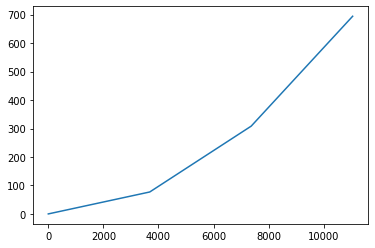

In [148]:
plt.plot(x0, z0)
plt.show()

In [149]:
rng = np.random.default_rng(seed=29)
q0=np.zeros(12*node_N)

In [150]:
for j in range(1,12):
    if j==1:  
        q0[(j-1)*node_N:j*node_N]=x0
    elif j==5:    
        q0[(j-1)*node_N:j*node_N]=z0
#     elif j==9:    
#         q0[(j-1)*node_N:j*node_N]=rng.standard_normal(node_N)
#     elif j==11:   
#         q0[(j-1)*node_N:j*node_N]=rng.standard_normal(node_N)

In [151]:
Re_b(Ret),Ws

(array([[[ 0.72175506,  0.55508794, -0.4134574 ],
         [-0.2523864 , -0.34515814, -0.90397288],
         [-0.64449263,  0.75679802, -0.10902299]],
 
        [[-0.04262597,  0.05639375,  0.99749826],
         [ 0.73428088, -0.67527309,  0.06955463],
         [ 0.67750617,  0.73540873, -0.01262468]],
 
        [[ 0.84236338, -0.3878521 , -0.37415864],
         [ 0.23985837,  0.89155687, -0.38418006],
         [ 0.48258874,  0.23387413,  0.84404443]],
 
        [[ 0.96647904, -0.24019925,  0.09067847],
         [ 0.24791982,  0.78130442, -0.57279941],
         [ 0.06673851,  0.57607961,  0.8146645 ]]]),
 array([941.76, 941.76, 941.76, 941.76]))

In [152]:
np.einsum('it,ijk->ijk',Ws.reshape(node_N,1),Re_b(Ret))

array([[[ 679.72004139,  522.75961379, -389.37764332],
        [-237.68741558, -325.0561284 , -851.32549795],
        [-606.95737528,  712.72210376, -102.67348738]],

       [[ -40.14343559,   53.10937867,  939.40395788],
        [ 691.5163626 , -635.9451821 ,   65.50376495],
        [ 638.04821325,  692.57852758,  -11.88941971]],

       [[ 793.3041371 , -365.26358935, -352.36764033],
        [ 225.88902267,  839.63259357, -361.80541021],
        [ 454.48277536,  220.25329899,  794.88728056]],

       [[ 910.19130036, -226.21004978,   85.39735195],
        [ 233.48097097,  735.80125007, -539.43957418],
        [  62.851655  ,  542.52873784,  767.21844066]]])

In [153]:
np.einsum('i,ijk->ijk',Ws,Re_b(Ret))

array([[[ 679.72004139,  522.75961379, -389.37764332],
        [-237.68741558, -325.0561284 , -851.32549795],
        [-606.95737528,  712.72210376, -102.67348738]],

       [[ -40.14343559,   53.10937867,  939.40395788],
        [ 691.5163626 , -635.9451821 ,   65.50376495],
        [ 638.04821325,  692.57852758,  -11.88941971]],

       [[ 793.3041371 , -365.26358935, -352.36764033],
        [ 225.88902267,  839.63259357, -361.80541021],
        [ 454.48277536,  220.25329899,  794.88728056]],

       [[ 910.19130036, -226.21004978,   85.39735195],
        [ 233.48097097,  735.80125007, -539.43957418],
        [  62.851655  ,  542.52873784,  767.21844066]]])

In [154]:
def static_func(Q):
    t=0
 
    x,y,z=Q[0:node_N],Q[2*node_N:3*node_N],Q[4*node_N:5*node_N]
    dx,dy,dz=Q[1*node_N:2*node_N],Q[3*node_N:4*node_N],Q[5*node_N:6*node_N]
    φ,θ,ψ=Q[6*node_N:7*node_N],Q[8*node_N:9*node_N],Q[10*node_N:11*node_N]
    Ret = Re_t(φ,θ,ψ)

    
    dφ,dθ,dψ=Q[7*node_N:8*node_N],Q[9*node_N:10*node_N],Q[11*node_N:12*node_N]
    
    η=[x[-1],y[-1],z[-1],φ[-1],θ[-1],ψ[-1]]
    
    tau_force=np.array([-Fx_0,0,0,0,0,0])

    
    
#     C=ne(x,y,z,Ret)
#     a,b,c=C[:,0],C[:,1],C[:,2]

#     Z0=tau_force[:3]

    Z0=np.dot(Re_b(Ret),tau_force[:3])
#     Z1 = d_s(ne, x, y, z, Ret, ωe(φ,θ,ψ,None,None)).T
    Z1 = d_s(ne, x, y, z, Ret, phi(x,y,z,Ret,None)).T
    DT_0=np.zeros((3,3))
    Z2=ne_(dx,dy,dz,DT_0,Ret).T
    
    
    Z =  Z1 + Z2 + Z0
    
############################################################    
#     ddx,ddy, ddz = np.linalg.solve(np.einsum('i,ijk->ijk',Ws,Re_b(Ret)),Z).T 
#     ddx,ddy, ddz = np.linalg.solve(Ws[0]*Re_b(Ret),Z).T
    ddx,ddy, ddz = np.linalg.solve(Ws[0]*Re_b(Ret),Z).T
#     tmp=np.linalg.solve(Ret,np.vstack([ddx_phi, ddy_phi, ddz_phi]).T)
#     ddx, ddy, ddz = tmp[:,0],tmp[:,1],tmp[:,2]
    
#     tmp=phi(ddx_phi,ddy_phi, ddz_phi, Ret)
#     ddx, ddy, ddz = tmp[:,0],tmp[:,1],tmp[:,2]
############################################################    
#     ans_x=[]
#     ans_y=[]
#     ans_z=[]
#     RRRR=Re_b(Ret)
#     for i in range(len(RRRR)):
#         a,b,c=1/Ws*np.linalg.lstsq(RRRR[i],Z[i], rcond=None)[0]
#         ans_x.append(a)
#         ans_y.append(b)
#         ans_z.append(c)
    
#     ddx,ddy, ddz = np.array(ans_x),np.array(ans_y),np.array(ans_z)    
    
   
    C0=np.einsum('ijk,kp->ijp',np.einsum('ijk,ikr->ijr',np.linalg.inv(Π(φ,θ,ψ).astype(np.float32)),
                        Re_b(Ret)),tau_force[3:].reshape(3,1)) 
#     C3= d_s(me_[:,0],me_[:,1],me_[:, 2],x,y,z).astype(np.float32).T
    C3=d_me(φ,θ,ψ,Ret,  ωe,ωe(φ,θ,ψ,None,None))
    B_ =C3
    B=(B_ + C0.squeeze()
      )

    A2 = Irho_e(Ret).astype(np.float32)
    A3=Π(φ,θ,ψ).astype(np.float32)
    A=np.einsum('ijk,ikr->ijr',A2,A3)
#     A=np.einsum('ijk,ikr->ijr', Re_b(Ret), np.einsum('ijk,ikr->ijr',A2,A3))


#############
    ddφ,ddθ,ddψ = np.linalg.solve(A,B).T
#############################################




#     ans_φ=[]
#     ans_θ=[]
#     ans_ψ=[]
#     for i in range(len(A)):
#         a,b,c=np.linalg.lstsq(A[i],B[i], rcond=None)[0]
#         ans_φ.append(a)
#         ans_θ.append(b)
#         ans_ψ.append(c)
    
#     ddφ,ddθ,ddψ=np.array(ans_φ),np.array(ans_θ),np.array(ans_ψ)
    
    

    ans=np.concatenate([dx, ddx, dy, ddy, dz, ddz, dφ, ddφ, dθ, ddθ, dψ, ddψ], axis=0)
  
 
    return ans
    

In [155]:
q0

array([    0.        ,  3684.22828149,  7368.45656297, 11052.68484446,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,    77.06804645,   308.4070593 ,   694.42189511,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ])

In [156]:
root = fsolve(static_func, q0)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


In [157]:
root

array([    0.        ,  3684.22828149,  7368.45656297, 11052.68484446,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,    77.06804645,   308.4070593 ,   694.42189511,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ])

In [158]:
x0_,z0_=root[:node_N],root[4*node_N:5*node_N]

In [159]:
x0

[0.0, 3684.228281487207, 7368.456562974414, 11052.68484446162]

In [160]:
x0_

array([    0.        ,  3684.22828149,  7368.45656297, 11052.68484446])

In [161]:
z0

[0.0, 77.06804644731459, 308.40705929683963, 694.4218951076863]

In [162]:
z0_

array([  0.        ,  77.06804645, 308.4070593 , 694.42189511])

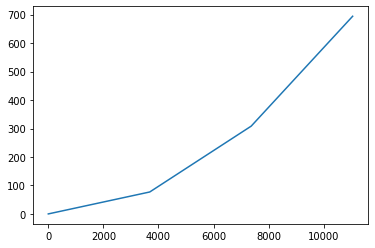

In [163]:
plt.plot(x0_, z0_)
plt.show()

In [164]:
for j in range(1,12):
    if j==1:  
        q0[(j-1)*node_N:j*node_N]=x0_
    elif j==5:    
        q0[(j-1)*node_N:j*node_N]=z0_
#     elif j==9:    
#         q0[(j-1)*node_N:j*node_N]=rng.standard_normal(node_N)
#     elif j==11:   
#         q0[(j-1)*node_N:j*node_N]=rng.standard_normal(node_N)
    elif j==9:    
        q0[(j-1)*node_N:j*node_N]=np.array([0,0,0,0.1])
    elif j==11:   
        q0[(j-1)*node_N:j*node_N]=np.array([0,0,0,0.1])

In [165]:
# q0[10*node_N]=q0[8*node_N]=0

In [166]:
q0

array([0.00000000e+00, 3.68422828e+03, 7.36845656e+03, 1.10526848e+04,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 7.70680464e+01, 3.08407059e+02, 6.94421895e+02,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.00000000e-01,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.00000000e-01,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00])

### Vessle Sim

In [167]:
sampleTime = 0.01                 # sample time [seconds]
N = 5000                         # number of samples

In [176]:
vehicle=semisub('DPcontrol',10.,-10.,40.0,0,0) 

In [177]:
[simTime, simData] = simulate(N, sampleTime, vehicle)

In [178]:
ans_t=[]
sum_=0
for i in range(simData.shape[0]):
    ans_t.append(sum_)
    sum_+=0.01

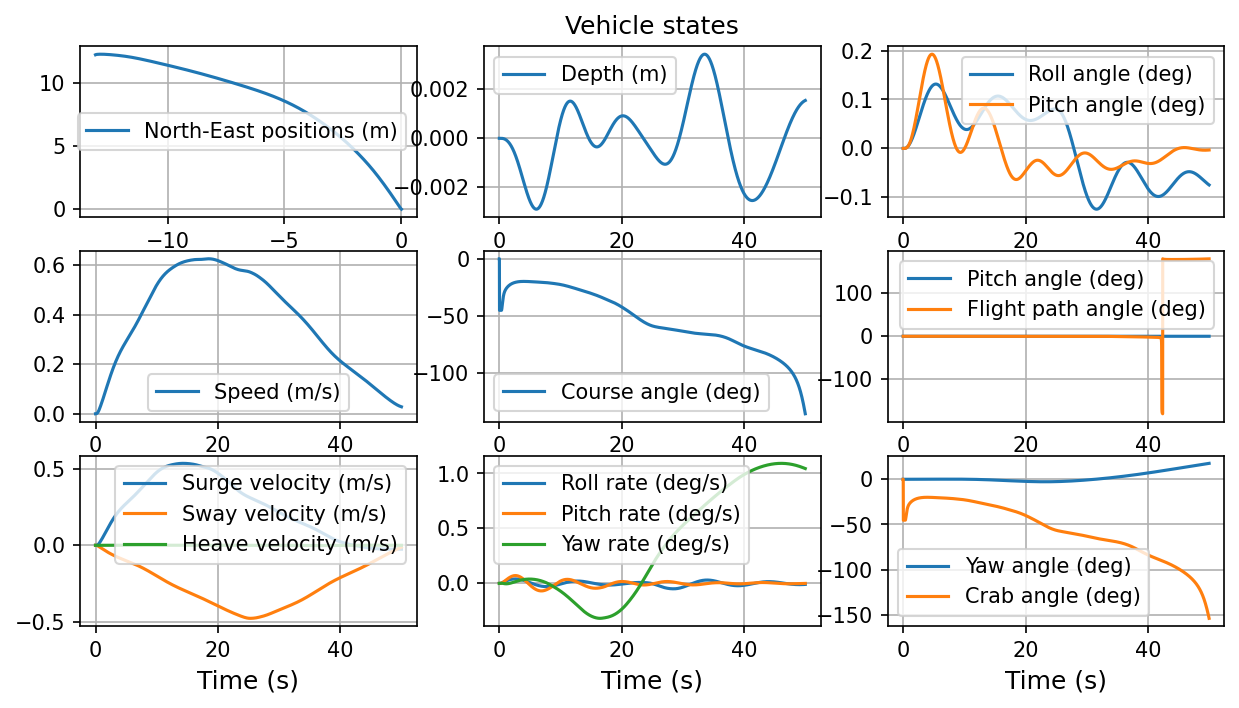

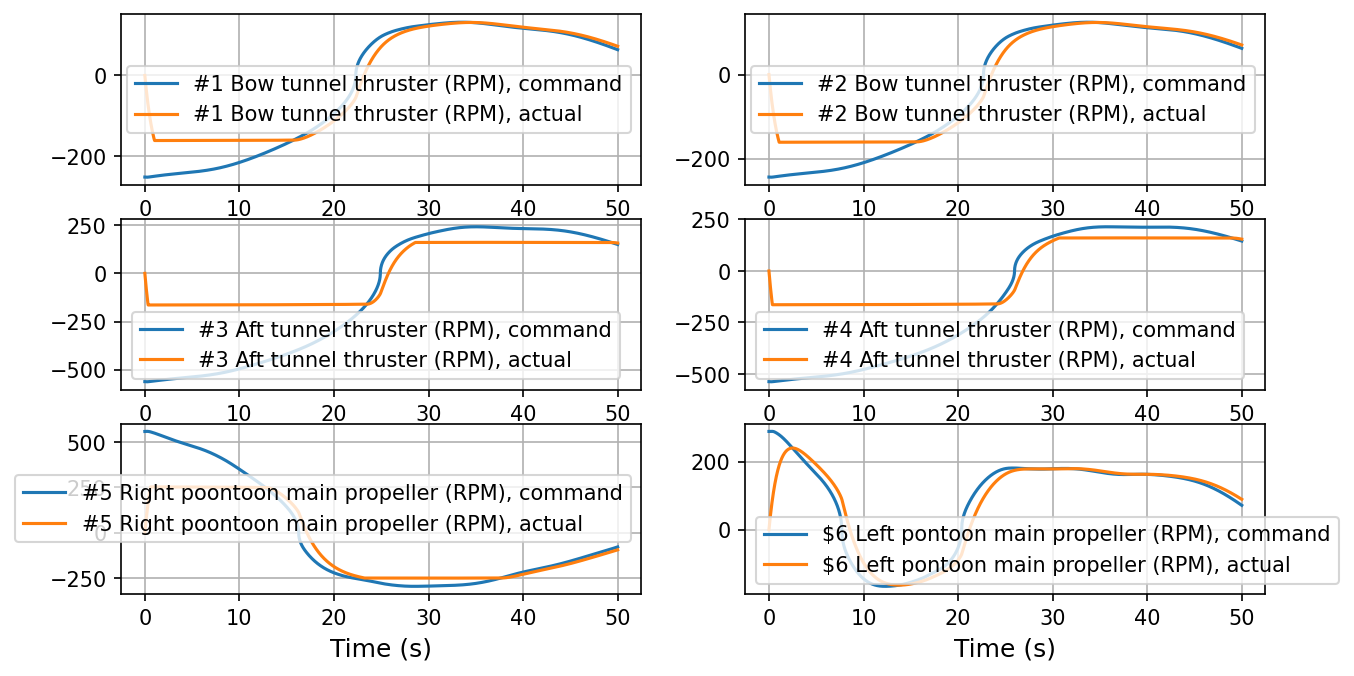

In [179]:
plotVehicleStates(simTime, simData, 1)                    
plotControls(simTime, simData, vehicle, 2)

In [180]:
numDataPoints = 5                 # number of 3D data points
FPS = 10                            # frames per second (animated GIF)
filename = '3D_animation.gif'       # data file for animated GIF
browser = 'safari'       

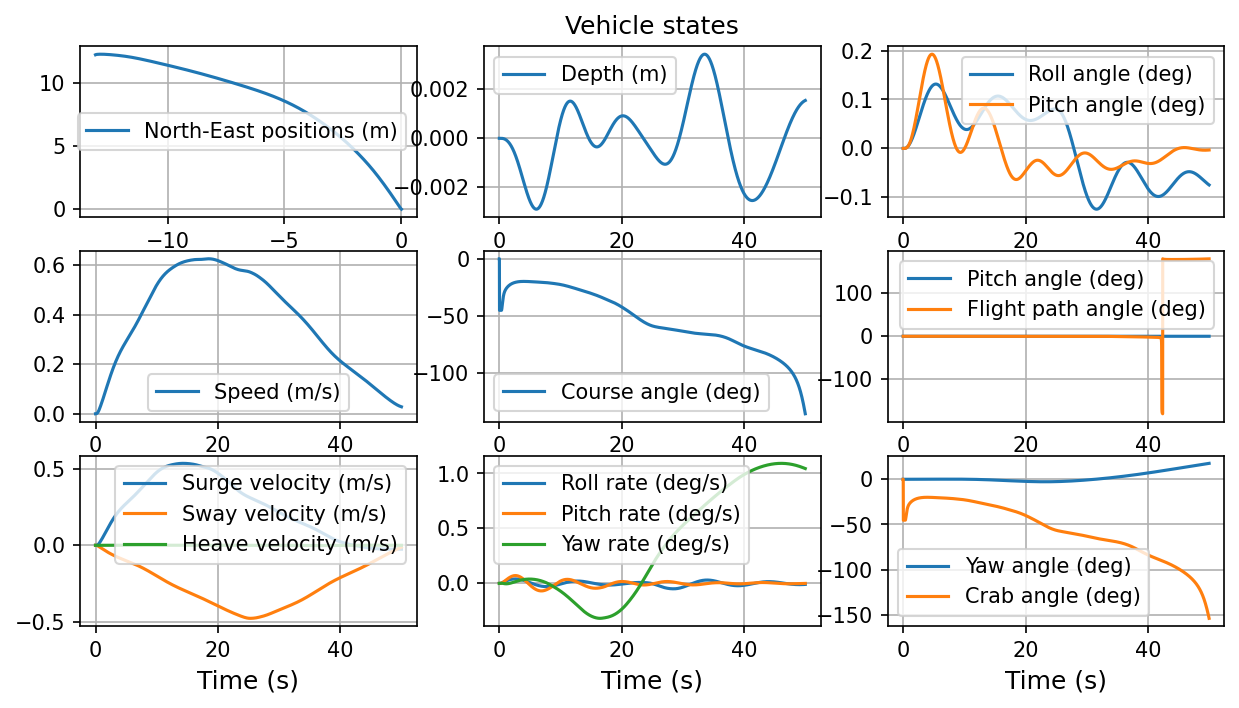

In [181]:
plotVehicleStates(simTime, simData, 3)

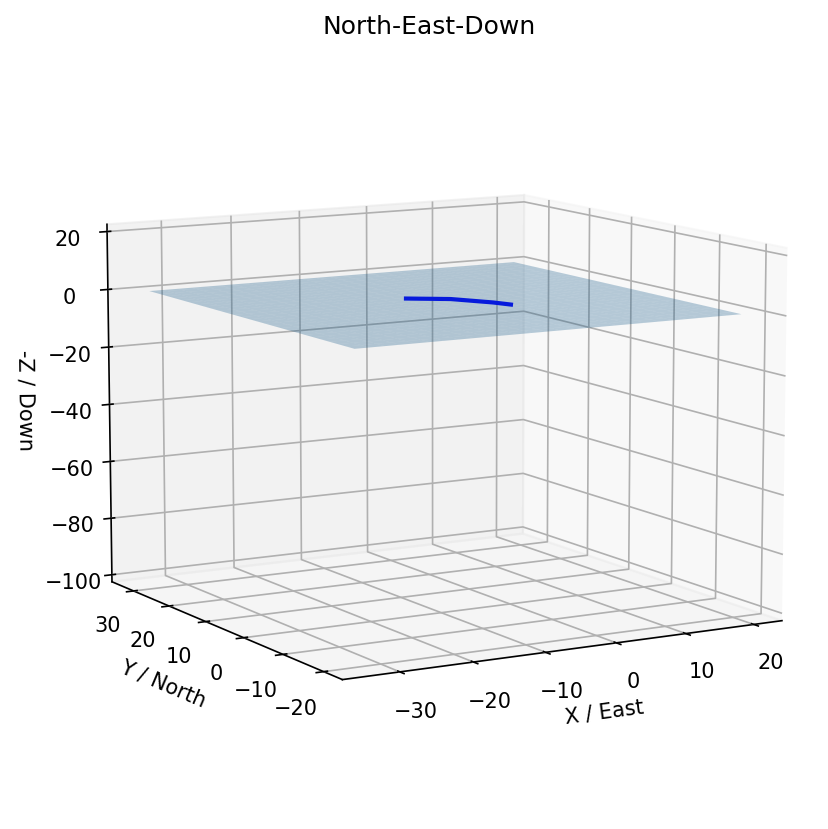

In [182]:
plot3D(simData, numDataPoints, FPS, filename, 3)  

In [189]:
diff=np.diff(simData,axis=0)
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

### Dynamics

In [253]:
# def grayscott1d(Q,p,t):
def grayscott1d(t, Q):
    print(t)
     
    x,y,z=Q[0:node_N],Q[2*node_N:3*node_N],Q[4*node_N:5*node_N]
    
    idx = find_nearest(np.array(ans_t),  t) #!!!!!!!!!!!!!!!!!!!!!

    # State vectors
    x_ve = simData[:, 0][idx]
    y_ve = simData[:, 1][idx]
    z_ve = simData[:, 2][idx]
    x[-1]=x_ve+x0_[-1]
    y[-1]=y_ve
    z[-1]=z_ve+z0_[-1]
    phi_ve = ssa(simData[:, 3][idx])
    theta_ve = ssa(simData[:, 4][idx])
    psi_v = ssa(simData[:, 5][idx])
    
    
    u_ve = simData[:, 6][idx]
    v_ve = simData[:, 7][idx]
    w_ve = simData[:, 8][idx]
    p_ve = simData[:, 9][idx]
    q_ve = simData[:, 10][idx]
    r_ve = simData[:, 11][idx]
    
#     du_ve=diff[:, 6][idx]/sampleTime
#     dv_ve = diff[:, 7][idx]/sampleTime
#     dw_ve = diff[:, 8][idx]/sampleTime
#     dp_ve = diff[:, 9][idx]/sampleTime
#     dq_ve = diff[:, 10][idx]/sampleTime
#     dr_ve = diff[:, 11][idx]/sampleTime
    
    
    η=np.array([x[-1], y[-1], z[-1], phi_ve, theta_ve, psi_v])
    
    dη=np.array([u_ve, v_ve, w_ve, p_ve, q_ve, r_ve])
    
#     ddη=np.array([du_ve, dv_ve, dw_ve, dp_ve, dq_ve, dr_ve])
    
    
#     x[-1]=x0[-1]+10*np.sin(t)
#     x[-1]=x0_[-1]+100*np.sin(t)
#     y[-1]+=5*np.cos(t)
#     z[-1]=z0[-1]+2.5*np.sin(t)
#    z[-1]=z0_[-1]+2.5*np.sin(t)

#     x[0]=0
#     y[0]=0
#     z[0]=0

    dx,dy,dz=Q[1*node_N:2*node_N],Q[3*node_N:4*node_N],Q[5*node_N:6*node_N]
    
#     dx[0]=0
#     dy[0]=0
#     dz[0]=0

    φ,θ,ψ=Q[6*node_N:7*node_N],Q[8*node_N:9*node_N],Q[10*node_N:11*node_N]
    
    Ret = Re_t(φ,θ,ψ)

    dφ,dθ,dψ=Q[7*node_N:8*node_N],Q[9*node_N:10*node_N],Q[11*node_N:12*node_N]
    
#     η=[x[-1],y[-1],z[-1],φ[-1],θ[-1],ψ[-1]]
#     dη=[dx[-1],dy[-1],dz[-1],dφ[-1],dθ[-1],dψ[-1]]
    
    left=V.eq_left(η,dη)
#     hack =1
#     hack3=1
    
    # PD controller after 30 sec
#     if t<30:
#         ddη=np.linalg.lstsq(V.M, -left + tau(η, dη, wave_coef, Fx_0/η[0], 0, t), rcond=None)[0]
#     else:
    ddη=np.linalg.lstsq(V.M.astype(np.float32), left.astype(np.float32) 
                            - tau(η,dη, wave_coef, kp, kd, t).astype(np.float32)
                            , rcond=None)[0]
#     print('ddη', ddη)
 
    tau_force = V.tau(η,dη,ddη).astype(np.float32)
#     tau_force =tau(η,dη, wave_coef, kp, kd, t).astype(np.float32)
#     tau_force = hack*tau(η,dη, wave_coef, kp, kd, t) # simple motion 
#     print(tau_force)
#     tau_force = hack*tau(η,dη, wave_coef, kp, kd, t) # simple motion 
#     print(tau_force)
#     C=ne(x,y,z,Ret)
#     a,b,c=C[:,0],C[:,1],C[:,2]
#     Z0=tau_force[:3]
#     Z0=tau_force[:3]

    Z0=np.dot(Re_b(Ret),tau_force[:3])
#     print(Ret,Z0)
#     print(x,z)
   
    Z1 =d_s(ne, x, y, z, Ret, ωe(φ,θ,ψ,None,None)).T
#     Z1 =d_s(ne, x, y, z, Ret, phi(x,y,z,Ret,None)).T

    Z2=ne_(dx,dy,dz,DT,Ret).T
    
    Z= (Z1 + Z2 
        +Z0
       )
#     print(Z0, Z1, Z2)
############################################################    
#     ddx,ddy, ddz = 1/Ws*np.linalg.solve(Re_b(Ret),Z).T 
############################################################    
    ans_x=[]
    ans_y=[]
    ans_z=[]
    RRRR=Re_b(Ret)
#     hack2=1
#     hack4=1
    ddx,ddy, ddz = np.linalg.solve((Ws[0]*(node_N-1)+vessel_mass/L)*RRRR,Z).T 
    
#     for i in range(len(RRRR)):
      
#         a,b,c=np.linalg.lstsq((Ws[i] + vessel_mass)*[i]
# #                               +hack2*np.identity(3)
#                               , Z[i], rcond=None)[0]
#         ans_x.append(a)
#         ans_y.append(b)
#         ans_z.append(c)
# #         print(np.dot(Ws,RRRR[i]))
    
#     ddx,ddy, ddz = np.array(ans_x),np.array(ans_y),np.array(ans_z)
    
#     print(ddx,ddy, ddz)
    
#     tmp=np.linalg.solve(Ret,np.vstack([ddx_phi, ddy_phi, ddz_phi]).T)
#     ddx, ddy, ddz = tmp[:,0],tmp[:,1],tmp[:,2]
    
    
 
    
 

    C1=np.einsum('ijk,ik->ij', Irho_e(Ret).astype(np.float32),
                                                        np.einsum('ijk,ik->ij', Π(dφ,dθ,dψ).astype(np.float32), 
                                                                  np.array([dφ,dθ,dψ]).astype(np.float32).T))
    
#     print(np.einsum('ijk,ik->ij',Π(φ,θ,ψ).astype(np.float32),np.array([dφ,dθ,dψ]).astype(np.float32).T))
#     print(np.einsum('ijk,ik->ij',Irho_e(Ret).astype(np.float32),
#                            np.einsum('ijk,ik->ij',Π(φ,θ,ψ).astype(np.float32),np.array([dφ,dθ,dψ]).astype(np.float32).T)))
    C2= np.cross(np.einsum('ijk,ik->ij',Π(φ,θ,ψ).astype(np.float32),np.array([dφ,dθ,dψ]).astype(np.float32).T),
                 np.einsum('ijk,ik->ij',Irho_e(Ret).astype(np.float32),
                           np.einsum('ijk,ik->ij',Π(φ,θ,ψ).astype(np.float32),np.array([dφ,dθ,dψ]).astype(np.float32).T)))

#     C3= d_s(me_[:,0],me_[:,1],me_[:, 2],x,y,z).astype(np.float32).T
    C3=d_me(φ,θ,ψ,Ret, ωe, ωe(φ,θ,ψ,None,None))
#     print(d_s(phi,x,y,z,Ret).T)
#     print(d_s(phi,x,y,z,Ret, phi(x,y,z,Ret,None)))
    C4= np.cross(d_s(phi,x,y,z,Ret, phi(x,y,z,Ret,None)).T, ne(x,y,z,Ret, phi(x,y,z,Ret,None)))

    K1=np.einsum('ijk,ik->ij',Π(φ,θ,ψ).astype(np.float32),np.array([dφ,dθ,dψ]).astype(np.float32).T).T

    C5= np.einsum('ijk,ik->ij',Ret, -np.dot(DR,K1).astype(np.float32).T)
#     print(np.linalg.inv(Π(φ,θ,ψ).astype(np.float32)).shape)

#     C0=np.einsum('ijk,kp->ijp',
#                  np.linalg.inv(Π(φ,θ,ψ)), tau_force[3:].reshape(3,1)
#                 ) 
    C0=np.einsum('ijk,kp->ijp',np.einsum('ijk,ikr->ijr',np.linalg.inv(Π(φ,θ,ψ).astype(np.float32)),
                        Re_b(Ret)),tau_force[3:].reshape(3,1)) 
#     print(C1.shape,C2.shape,C3.shape,C4.shape,C5.shape)
    B_ =(
        -C1
        -C2
        +C3
        +C4
        +C5
    )
    B= B_ +C0.squeeze()
       

    A2 = Irho_e(Ret).astype(np.float32)
    A3=Π(φ,θ,ψ).astype(np.float32)

    A=np.einsum('ijk,ikr->ijr',A2,A3)
#     A=np.einsum('ijk,ikr->ijr', Re_b(Ret), np.einsum('ijk,ikr->ijr',A2,A3))

############################################
#     ddφ,ddθ,ddψ = np.linalg.solve(A,B).T
#############################################

    ans_φ=[]
    ans_θ=[]
    ans_ψ=[]
    hack5=1
    for i in range(len(A)):
#         if i==len(A)-1:
#             hack5=vessel_inertia_coef
        a,b,c=np.linalg.lstsq(A[i]
#                               +hack2*np.identity(3)
                              ,B[i], rcond=None)[0]
        ans_φ.append(a)
        ans_θ.append(b)
        ans_ψ.append(c)
    
    ddφ,ddθ,ddψ=np.array(ans_φ),np.array(ans_θ),np.array(ans_ψ)
    ddφ*=np.exp(-t)
    ddθ*=np.exp(-t)
    ddψ*=np.exp(-t)
#     ddx[-1],ddy[-1],ddz[-1],ddφ[-1],ddθ[-1],ddψ[-1]=ddη
#     print(ddφ,ddθ,ddψ)

    ddx[0],ddy[0],ddz[0],ddφ[0],ddθ[0],ddψ[0]=0,0,0,0,0,0
    A1111=np.concatenate([dx, ddx, dy, ddy, dz, ddz, dφ, ddφ, dθ, ddθ, dψ, ddψ], axis=0)
#     A1111=np.concatenate([dx, ddx, 
#                           np.zeros(node_N), np.zeros(node_N),
#                           dz, ddz,
#                           np.zeros(node_N),  np.zeros(node_N),
#                           np.zeros(node_N), np.zeros(node_N),
#                           np.zeros(node_N),  np.zeros(node_N),
#                           ], axis=0)

        

#     print(A1111)
    return A1111

In [254]:
# ode15s = scipy.integrate.ode(grayscott1d)
# # ode15s.set_integrator('vode', method='bdf', order=15, nsteps=3000)
# ode15s.set_integrator('vode',  order=15, nsteps=3000)
# ode15s.set_initial_value(q0, 0)

In [255]:
# us=ode15s.integrate(10)

In [256]:
tspan = (0., 1)
# tspan = (0., 10)

In [257]:
startTime1 = datetime.now()
# prob = de.ODEProblem(grayscott1d, q0, tspan)
# us = de.solve(prob)
us=solve_ivp(grayscott1d,  tspan, q0, 
#              nfev=842
#              method='LSODA',
#              method= 'BDF'
#              vectorized=True
#              min_step=1e-6
#              rtol=1e9, atol=1e9
            )
# us=ode15s.integrate(10)
print(datetime.now() - startTime1)

0.0
9.211905923786252e-13
1.8423811847572507e-11
2.7635717771358756e-11
7.369524739029003e-11
8.188360821143336e-11
9.211905923786253e-11
9.211905923786253e-11
2.763571777135876e-10
3.684762369514501e-10
8.290715331407627e-10
9.10955141352196e-10
1.0133096516164877e-09
1.0133096516164877e-09
2.855690836373738e-09
3.776881428752363e-09
8.382834390645489e-09
9.201670472759822e-09
1.0225215575402739e-08
1.0225215575402739e-08
2.8649027422975242e-08
3.786093334676149e-08
8.392046296569276e-08
9.210882378683609e-08
1.0234427481326526e-07
1.0234427481326526e-07
2.865823932889903e-07
3.7870145252685274e-07
8.392967487161654e-07
9.211803569275987e-07
1.0235348671918904e-06
1.0235348671918904e-06
2.865916051949141e-06
3.787106644327766e-06
8.393059606220891e-06
9.211895688335225e-06
1.0235440790978141e-05
1.0235440790978141e-05
2.6224929107416632e-05
3.4219673265635875e-05
7.41933940567321e-05
8.129983330848253e-05
9.018288237317058e-05
9.018288237317058e-05
0.00011446359675444693
0.00012660395

0.01455355228370389
0.014585685290116635
0.014625851548132568
0.014625851548132568
0.014328499663744143
0.014360571882621626
0.01452093297700904
0.014549441616011247
0.014585077414764006
0.014585077414764006
0.014649221852518973
0.014681294071396456
0.01484165516578387
0.014870163804786077
0.014905799603538836
0.014905799603538836
0.014976916897011892
0.01501247554374842
0.015190268777431062
0.015221876463419087
0.015261386070904118
0.015261386070904118
0.015337487891569053
0.01537553880190152
0.015565793353563858
0.015599616384970497
0.015641895174228794
0.015641895174228794
0.015714053928849767
0.015750133306160253
0.015930530192712688
0.01596260075032201
0.01600268894733366
0.01600268894733366
0.01570616958860273
0.0157383067957897
0.01589899283172454
0.015927559238112957
0.015963267246098478
0.015963267246098478
0.016027541660472416
0.016059678867659383
0.016220364903594225
0.01624893130998264
0.016284639317968162
0.016284639317968162
0.016355725487951108
0.016391268572942583
0.016

0.034488319055567214
0.03451791319866238
0.03455490587753134
0.03455490587753134
0.0346241182211686
0.034658724392987235
0.03483175525208038
0.03486251629369694
0.03490096759571764
0.03490096759571764
0.034972380496662986
0.03500808694713566
0.03518661919949903
0.03521835826658585
0.03525803210044438
0.03525803210044438
0.03532853476456014
0.03536378609661801
0.03554004275690741
0.035571377274292194
0.035610545421023175
0.035610545421023175
0.03567804399141669
0.035711793276613446
0.03588053970259723
0.03591053906721658
0.03594803827299075
0.03594803827299075
0.03601398712550421
0.03604696155176094
0.03621183368304458
0.03624114428416167
0.03627778253555804
0.03627778253555804
0.03634555443589543
0.036379440386064124
0.03654887013690761
0.03657899098150201
0.036616642037245004
0.036616642037245004
0.036687602720047875
0.036723083061449315
0.036900484768456504
0.03693202284970222
0.036971445451259376
0.036971445451259376
0.037043188535605474
0.037079060077778524
0.03725841778864378
0.03

0.05829273222927197
0.058335293237668596
0.058335293237668596
0.058407836426396166
0.05844410802075995
0.05862546599257887
0.05865770740979112
0.05869800918130644
0.05869800918130644
0.05839943304313565
0.05843150294586918
0.05859185245953682
0.05862035903974439
0.05865599226500387
0.05865599226500387
0.05872013207047092
0.05875220197320445
0.05891255148687209
0.058941058067079666
0.058976691292339144
0.058976691292339144
0.05904785743653252
0.0590834405086292
0.05926135586911264
0.05929298526653192
0.059332522013306015
0.059332522013306015
0.05940858615542601
0.05944661822648601
0.059636778581785996
0.05967058486717266
0.05971284272390599
0.05971284272390599
0.0597850649068951
0.05982117599838966
0.060001731455862434
0.060033830203857594
0.06007395363885154
0.06007395363885154
0.05977717559107642
0.059809342024661635
0.0599701741925877
0.05999876657799678
0.06003450705975812
0.06003450705975812
0.06009883992692855
0.06013100636051376
0.06029183852843983
0.06032043091384891
0.060356171

0.07936391567363368
0.07936391567363368
0.07943140761504962
0.07946515358575758
0.0796338834392974
0.07966387985770448
0.07970137538071334
0.07970137538071334
0.07976333751643654
0.07979431858429814
0.07994922392360614
0.07997676265059422
0.08001118605932933
0.08001118605932933
0.08007547560225463
0.08010762037371727
0.08026834423103049
0.08029691736121952
0.08033263377395579
0.08033263377395579
0.0804048965078682
0.0804410278748244
0.08062168470960542
0.08065380148023316
0.08069394744351782
0.08069394744351782
0.080770641705977
0.08080898883720658
0.08100072449335452
0.08103481083222527
0.0810774187558137
0.0810774187558137
0.08114888169500688
0.08118461316460347
0.08136327051258642
0.0813950318188945
0.0814347334517796
0.0814347334517796
0.08114065938368192
0.08117227969761602
0.08133038126728656
0.08135848821300577
0.08139362189515478
0.08139362189515478
0.081456862523023
0.0814884828369571
0.08164658440662764
0.08167469135234685
0.08170982503449586
0.08170982503449586
0.08178119933

0.09963976063069427
0.09963976063069427
0.0997152919654106
0.09975305763276876
0.09994188596955957
0.09997545545165572
0.1000174173042759
0.1000174173042759
0.10008938437803028
0.10012536791490746
0.10030528559929341
0.10033727096540647
0.1003772526730478
0.1003772526730478
0.10008210361379859
0.10011444676855992
0.10027616254236664
0.10030491201326562
0.10034084885188933
0.10034084885188933
0.10040553516141203
0.10043787831617336
0.10059959408998008
0.10062834356087906
0.10066428039950277
0.10066428039950277
0.10073514814349994
0.10077058201549854
0.10094775137549149
0.10097924815060134
0.10101861911948866
0.10101861911948866
0.10109372833292124
0.10113128293963752
0.10131905597321897
0.10135243784585567
0.10139416518665155
0.10139416518665155
0.1014657757897612
0.10150158109131602
0.10168060759909013
0.10171243453380553
0.10175221820219978
0.10175221820219978
0.10181700343938492
0.10184939605797749
0.10201135915094035
0.1020401525896893
0.1020761443881255
0.1020761443881255
0.1021388

0.12031764407998952
0.1203819707743643
0.12041413412155169
0.12057495085748864
0.12060354049943299
0.12063927755186342
0.12063927755186342
0.12071021287089975
0.12074568053041793
0.12092301882800877
0.12095454563646936
0.1209939541470451
0.1209939541470451
0.12106951912511711
0.12110730161415312
0.12129621405933316
0.12132979849403183
0.12137177903740518
0.12137177903740518
0.12144378002726607
0.1214797805221965
0.12165978299684872
0.1216917834367869
0.12173178398670961
0.12173178398670961
0.1214364141724188
0.1214687317399256
0.12163031957745966
0.12165904630413238
0.12169495471247328
0.12169495471247328
0.1217595898474869
0.12179190741499371
0.12195349525252777
0.12198222197920049
0.12201813038754139
0.12201813038754139
0.12208899681082919
0.1221244300224731
0.1223015960806926
0.12233309226882051
0.1223724625039804
0.1223724625039804
0.12244762163425495
0.12248520119939223
0.12267309902507861
0.12270650308297841
0.12274825815535316
0.12274825815535316
0.1228199298732328
0.12285576573

0.14130813665947217
0.14135062345209082
0.14135062345209082
0.14142299418006377
0.14145917954405027
0.14164010636398267
0.14167227113197065
0.1417124770919556
0.1417124770919556
0.14141474154544664
0.14144680059212456
0.14160709582551412
0.1416355927558945
0.14167121391886994
0.14167121391886994
0.14173533201222577
0.14176739105890368
0.14192768629229324
0.14195618322267362
0.14199180438564907
0.14199180438564907
0.14206293198987618
0.14209849579198977
0.1422763148025576
0.14230792707110296
0.1423474424067847
0.1423474424067847
0.14242335203589848
0.14246130685045538
0.1426510809232398
0.14268481853617926
0.14272699055235358
0.14272699055235358
0.14279909097668264
0.1428351411888472
0.1430153922496699
0.14304743688270502
0.14308749267399895
0.14308749267399895
0.14279140387750633
0.1428236105400827
0.14298464385296458
0.1430132719974769
0.14304905717811733
0.14304905717811733
0.14311347050327008
0.14314567716584647
0.14330671047872834
0.14333533862324066
0.1433711238038811
0.1433711238

0.16193389360403013
0.16196950018036427
0.16196950018036427
0.16204071492999522
0.16207632230481067
0.16225435917888803
0.16228601017872402
0.16232557392851898
0.16232557392851898
0.16240180258581616
0.16243991691446477
0.16263048855770773
0.1626643679609509
0.1627067172150049
0.1627067172150049
0.16277897982954392
0.16281511113681343
0.162995767673161
0.1630278843907339
0.16306803028770003
0.16306803028770003
0.1627709538278406
0.16280307213425843
0.16296366366634765
0.1629922132720524
0.16302790027918335
0.16302790027918335
0.16309213689201904
0.16312425519843687
0.1632848467305261
0.16331339633623085
0.1633490833433618
0.1633490833433618
0.16342022817123325
0.16345580058516898
0.16363366265484763
0.16366528257834606
0.1637048074827191
0.1637048074827191
0.1637806045702055
0.1638185031139487
0.1640079958326647
0.1640416834271031
0.1640837929201511
0.1640837929201511
0.16415562568658854
0.16419154206980724
0.1643711239859008
0.164403049659873
0.16444295675233825
0.16444295675233825
0.

0.18333019299212885
0.18340145800028612
0.18343709050436474
0.1836152530247579
0.18364692636171667
0.18368651803291516
0.18368651803291516
0.18376287655877674
0.18380105582170753
0.18399195213636144
0.1840258892589666
0.184068310662223
0.184068310662223
0.18414062410875473
0.1841767808320206
0.1843575644483499
0.18438970375791955
0.1844298778948816
0.1844298778948816
0.18413247463384902
0.18416455661966205
0.1843249665487271
0.18435348386944977
0.1843891305203531
0.1843891305203531
0.18445329449197911
0.18448537647779215
0.1846457864068572
0.18467430372757987
0.1847099503784832
0.1847099503784832
0.1847811317187689
0.18481672238891172
0.18499467573962594
0.18502631189086402
0.18506585707991163
0.18506585707991163
0.18514192705596705
0.18517996204399476
0.18537013698413332
0.18540394586238018
0.18544620696018874
0.18544620696018874
0.18551840948832193
0.18555451075238855
0.18573501707272155
0.1857671070852252
0.18580721960085475
0.18580721960085475
0.1855105869922703
0.1855427770083111


0.2046872184312208
0.20475840819540103
0.20479400307749113
0.2049719774879417
0.20500361738313289
0.2050431672521219
0.2050431672521219
0.20512010437587969
0.20515857293775858
0.20535091574715303
0.2053851100243787
0.2054278528709108
0.2054278528709108
0.20550068644758793
0.2055371032359265
0.20571918717761928
0.20575155765614245
0.2057920207542964
0.2057920207542964
0.20549187886816994
0.2055238918667995
0.2056839568599473
0.20571241285872915
0.20574798285720644
0.20574798285720644
0.20581200885446557
0.20584402185309514
0.20600408684624294
0.20603254284502479
0.20606811284350207
0.20606811284350207
0.20613935473313866
0.20617497567795698
0.20635308040204847
0.20638474346410918
0.20642432229168506
0.20642432229168506
0.20650062927663348
0.2065387827691077
0.20672955023147876
0.2067634644470114
0.2068058572164272
0.2068058572164272
0.2068780621978328
0.2069141646885356
0.20709467714204963
0.20712676824489656
0.20716688212345524
0.20716688212345524
0.20686997043924815
0.2069020270506586

0.22550671919944712
0.22566174096236405
0.22568930038688262
0.2257237496675308
0.2257237496675308
0.22578795052451103
0.22582005095300117
0.22598055309545176
0.2260090868096652
0.22604475395243198
0.22604475395243198
0.2261168516573655
0.22615290050983225
0.226333144772166
0.2263651881965809
0.22640524247709953
0.22640524247709953
0.22648209203606823
0.22652051681555258
0.22671264071297428
0.22674679607251594
0.22678949027194298
0.22678949027194298
0.22686126864130116
0.22689715782598024
0.22707660374937572
0.22710850524686824
0.2271483821187339
0.2271483821187339
0.22685287904313414
0.2268845734287297
0.22704304535670758
0.22707121814390366
0.22710643412789874
0.22710643412789874
0.2271698228990899
0.22720151728468546
0.22735998921266334
0.22738816199985942
0.2274233779838545
0.2274233779838545
0.227494533522906
0.22753011129243172
0.22770800014006046
0.22773962482408333
0.22777915567911194
0.22777915567911194
0.2278558679377949
0.22789422406713636
0.22808600471384374
0.22812009905103

0.2484781923184708
0.2484781923184708
0.24854140766980354
0.24857301534546988
0.24873105372380172
0.24875914943550517
0.24879426907513447
0.24879426907513447
0.24885915504521564
0.24889159803025623
0.24905381295545914
0.2490826511643841
0.2491186989255403
0.2491186989255403
0.24919010740019554
0.24922581163752316
0.24940433282416127
0.24943606992400805
0.2494757412988165
0.2494757412988165
0.24955115074097747
0.24958885546205795
0.2497773790674604
0.2498108943750875
0.24985278850962137
0.24985278850962137
0.24992418128168448
0.24995987766771602
0.2501383595978738
0.2501700897187907
0.25020975236993687
0.25020975236993687
0.2502740719820186
0.2503062317880595
0.2504670308182638
0.2504956173125224
0.2505313504303456
0.2505313504303456
0.2505938559879494
0.25062510876675137
0.25078137266076095
0.25080915290858485
0.2508438782183648
0.2508438782183648
0.25091191762450965
0.2509459373275821
0.25111603584294423
0.2511462755790086
0.2511840752490891
0.2511840752490891
0.251259165312464
0.2512

0.2726675943704573
0.27282800765181053
0.27285652556849554
0.2728921729643518
0.2728921729643518
0.2729563382768931
0.2729884209331637
0.27314883421451697
0.273177352131202
0.27321299952705824
0.27321299952705824
0.27328406099277475
0.273319591725633
0.27349724538992426
0.27352882826357605
0.27356830685564076
0.27356830685564076
0.27364423557690404
0.2736821999375357
0.2738720217406938
0.27390576783903303
0.2739479504619571
0.2739479504619571
0.2740200336038452
0.27405607517478925
0.2742362830295095
0.27426831998145973
0.2743083661713976
0.2743083661713976
0.2740123217473433
0.27404450739003644
0.274205435603502
0.27423404506367366
0.27426980688888825
0.27426980688888825
0.27433417817427447
0.2743663638169676
0.2745272920304332
0.2745559014906048
0.2745916633158194
0.2745916633158194
0.2746626073933542
0.27469807943212154
0.27487543962595845
0.274906970327085
0.2749463837034932
0.2749463837034932
0.2750218675550785
0.2750596094808711
0.27524831910983427
0.2752818674883166
0.27532380296

0.29495087025944283
0.2950174589961604
0.29505075336451914
0.29521722520631294
0.29524682020040965
0.2952838139430305
0.2952838139430305
0.29535038151733045
0.29538366530448046
0.2955500842402303
0.29557966982880807
0.2956166518145303
0.2956166518145303
0.2956859110738777
0.2957205407035514
0.29589368885192
0.2959244707449633
0.29596294811126744
0.29596294811126744
0.29603452830810884
0.2960703184065296
0.2962492688986331
0.2962810823194515
0.2963208490954745
0.2963208490954745
0.29639148296925727
0.2964267999061487
0.2966033845906056
0.29663477742339794
0.29667401846438834
0.29667401846438834
0.29674147840496246
0.2967752083752495
0.29694385822668473
0.29697384042249547
0.29701131816725884
0.29701131816725884
0.2970770883901373
0.29710997350157653
0.2972743990587726
0.29730363026894085
0.2973401692816511
0.2973401692816511
0.29740778386723377
0.2974415911600251
0.29761062762398177
0.2976406785509074
0.29767824220956446
0.29767824220956446
0.29774925847008515
0.2977847666003455
0.29796

0.3175988227073955
0.3176344480785511
0.3176344480785511
0.31770554398819445
0.3177410919430161
0.3179188317171243
0.31795042989918804
0.31798992762676764
0.31798992762676764
0.3180659573073968
0.31810397214771136
0.31829404634928415
0.31832783731845266
0.3183700760299133
0.3183700760299133
0.3184421423948034
0.3184781755772485
0.3186583414894738
0.3186903709849805
0.3187304078543639
0.3187304078543639
0.3184342879086305
0.3184663938479891
0.318626923544782
0.3186554621575452
0.3186911354234992
0.3186911354234992
0.3187553473022164
0.318787453241575
0.3189479829383679
0.3189765215511311
0.3190121948170851
0.3190121948170851
0.3190832503063291
0.3191187780509511
0.31929641677406123
0.319327996991503
0.31936747226330525
0.31936747226330525
0.3194434126516136
0.31948138284576777
0.31967123381653867
0.31970498510023126
0.319747174204847
0.319747174204847
0.3198193396541225
0.3198554223787603
0.32003583600194907
0.3200679095349604
0.3201080014512246
0.3201080014512246
0.31981159629688877
0.

0.34046857561903876
0.3405012947684983
0.34066489051579585
0.34069397420420433
0.3407303288147149
0.3407303288147149
0.3407946013654705
0.34082673764084837
0.34098741901773744
0.34101598459585103
0.3410516915684931
0.3410516915684931
0.34112012769701355
0.3411543457612738
0.34132543608257504
0.34135585213969527
0.3413938722110955
0.3413938722110955
0.3414673616793759
0.34150410641351614
0.3416878300842171
0.3417204920701195
0.3417613195524975
0.3417613195524975
0.34183436579475457
0.34187088891588313
0.34205350452152583
0.3420859695180845
0.3421265507637829
0.3421265507637829
0.34219398169537363
0.34222769716116896
0.34239627449014576
0.34242624379307496
0.3424637054217365
0.3424637054217365
0.34252722174954053
0.3425589799134426
0.34271777073295273
0.34274600021197676
0.3427812870607568
0.3427812870607568
0.34284703551463763
0.34287990974157806
0.3430442808762802
0.3430735024113383
0.34311002933016105
0.34311002933016105
0.3431818342472067
0.3432177367057295
0.3433972489983437
0.34342

0.36584325218480335
0.36584325218480335
0.36591543067862403
0.3659515199255344
0.36613196616008603
0.366164045490673
0.3662041446539067
0.3662041446539067
0.36627530049269286
0.36631087841208587
0.36648876800905117
0.36652039282628945
0.3665599238478373
0.3665599238478373
0.36662713875418007
0.36666074620735145
0.3668287834732083
0.3668586567649162
0.36689599837955106
0.36689599837955106
0.3669611393184791
0.3669937097879432
0.36715656213526343
0.3671855136636759
0.3672217030741915
0.3672217030741915
0.36728905347856905
0.3673227286807578
0.36749110469170176
0.36752103820475845
0.3675584550960793
0.3675584550960793
0.3676299407364258
0.367665683556599
0.3678443976574651
0.36787616905317466
0.3679158832978116
0.3679158832978116
0.36798850470044076
0.3680248154017553
0.3682063689083281
0.3682386450872744
0.36827899031095723
0.36827899031095723
0.3683480995702486
0.3683826541998943
0.3685554273481227
0.3685861425744744
0.36862453660741407
0.36862453660741407
0.36868976547662
0.36872237991

0.3896984008338514
0.38973039358870815
0.38989035736299205
0.38991879536730917
0.3899543428727056
0.3899543428727056
0.3900183283824191
0.3900503211372759
0.3902102849115598
0.3902387229158769
0.39027427042127333
0.39027427042127333
0.39034554282146927
0.3903811790215672
0.3905593600220571
0.3905910366443664
0.39063063242225304
0.39063063242225304
0.39070701010905573
0.3907451989524571
0.3909361431694638
0.39097008880804274
0.3910125208562665
0.3910125208562665
0.3910848062374642
0.3911209489280631
0.3913016623810574
0.3913337892171453
0.39137394776225515
0.39137394776225515
0.39107663579311963
0.3911086932615462
0.3912689806036791
0.3912974761311694
0.39133309554053225
0.39133309554053225
0.3913972104773854
0.391429267945812
0.39158955528794487
0.39161805081543516
0.391653670224798
0.391653670224798
0.391724795158284
0.391760357625027
0.3919381699587419
0.39196978104029123
0.3920092948922279
0.3920092948922279
0.3920852370309413
0.39212320810029794
0.39231306344708133
0.39234681550873

0.41246558503722125
0.4126205987716675
0.4126481567689024
0.412682604265446
0.412682604265446
0.41274659945433445
0.41277859704877873
0.4129385850209999
0.4129670273271725
0.41300258020988834
0.41300258020988834
0.41307453446438863
0.4131105115916388
0.4132903972278896
0.41332237689655643
0.4133623514823899
0.4133623514823899
0.41343914585604385
0.4134775430428708
0.41366952897700565
0.4137036598097407
0.4137463233506596
0.4137463233506596
0.4138181350019735
0.41385404082763044
0.4140335699559152
0.4140654862453881
0.41410538160722915
0.41410538160722915
0.4138097391224106
0.4138414470082861
0.41399998643766367
0.41402817122510854
0.4140634022094147
0.4140634022094147
0.4141268179811657
0.4141585258670412
0.41431706529641876
0.41434525008386364
0.41438048106816977
0.41438048106816977
0.41445168459419174
0.41448728635720267
0.41466529517225753
0.4146969411838229
0.4147364986982795
0.4147364986982795
0.41481341613718214
0.4148518748566335
0.4150441684538902
0.41507835398229137
0.41512108

0.4337975217058711
0.43398517729701
0.43401853829099024
0.43406023953346556
0.43406023953346556
0.4341319612582966
0.4341678221207122
0.4343471264327899
0.434379002754937
0.43441884815762094
0.43441884815762094
0.43448371595386037
0.43451614985198006
0.43467831934257856
0.43470714947424055
0.434743187138818
0.434743187138818
0.43480584748392936
0.43483717765648505
0.43499382851926344
0.43502167756153515
0.4350564888643748
0.4350564888643748
0.4351244920925886
0.43515849370669546
0.4353285017772298
0.4353587254342137
0.4353965050054436
0.4353965050054436
0.43547138788422574
0.4355088293236168
0.4356960365205721
0.4357293178000308
0.43577091939935425
0.43577091939935425
0.43584559173712034
0.43588292790600336
0.4360696087504185
0.43610279645609235
0.4361442810881846
0.4361442810881846
0.4362115797732315
0.4362452291157549
0.4364134758283722
0.4364433863550597
0.4364807745134191
0.4364807745134191
0.4365426662432506
0.43657361210816636
0.4367283414327452
0.4367558488682259
0.4367902331625

0.4557398189191595
0.4557398189191595
0.4558043192894967
0.4558365694746653
0.4559978204005083
0.4560264872317693
0.4560623207708455
0.4560623207708455
0.45613334365654074
0.4561688550993883
0.4563464123136264
0.45637797804060204
0.4564174351993216
0.4564174351993216
0.45649294443417227
0.45653069905159754
0.45671947213872416
0.4567530317986578
0.4567949813735748
0.4567949813735748
0.4568668184216833
0.4569027369457375
0.45708232956600864
0.45711425714294573
0.4571541666141171
0.4571541666141171
0.45685956699007624
0.4568918597983269
0.45705332383958036
0.45708202855802543
0.4571179094560818
0.4571179094560818
0.4571824950725832
0.45721478788083386
0.4573762519220873
0.4574049566405324
0.4574408375385887
0.4574408375385887
0.4575117364191136
0.45754718585937604
0.4577244330606883
0.4577559436742549
0.45779533194121313
0.45779533194121313
0.4578705635350029
0.4579081793318978
0.45809625831637224
0.4581296945802788
0.458171489910162
0.458171489910162
0.4582432564146408
0.4582791396668802

0.4768671749809297
0.47702751244596836
0.47705601688419746
0.47709164743198385
0.47709164743198385
0.47715578241799933
0.47718784991100704
0.47734818737604573
0.47737669181427483
0.4774123223620612
0.4774123223620612
0.47748342246493836
0.47751897251637687
0.47769672277356967
0.47772832281929284
0.4777678228764468
0.4777678228764468
0.4778437890236548
0.4778817720972588
0.47807168746527884
0.4781054501973713
0.47814765361248684
0.47814765361248684
0.47821981261848656
0.47825589212148645
0.4784362896364857
0.4784683603058189
0.47850844864248543
0.47850844864248543
0.4782120529777195
0.4782442526603358
0.47840525107341747
0.47843387301352086
0.47846965043865014
0.47846965043865014
0.4785340498038828
0.4785662494864991
0.47872724789958077
0.47875586983968416
0.47879164726481344
0.47879164726481344
0.4788626028816027
0.4788980806899973
0.4790754697319704
0.47910700556165453
0.4791464253487597
0.4791464253487597
0.47922199428839085
0.47925977875820647
0.4794487011072844
0.479482287302676
0.

0.4998224222982374
0.4998868723467732
0.49991909737104107
0.5000802224923805
0.5001088669583964
0.5001446725409162
0.5001446725409162
0.5002155749345553
0.5002510261313748
0.5004282821154726
0.5004597942904233
0.5004991845091117
0.5004991845091117
0.5005745814880331
0.5006122799774939
0.5008007724247975
0.500834282193207
0.5008761694037189
0.5008761694037189
0.5009480022515783
0.5009839186755081
0.5011635007951565
0.5011954265053162
0.5012353336430159
0.5012353336430159
0.5012999943839854
0.5013323247544701
0.5014939766068939
0.5015227147139915
0.5015586373478634
0.5015586373478634
0.5016210015372037
0.5016521836318738
0.5018080941052244
0.501835811522709
0.5018704582945647
0.5018704582945647
0.5019379725498438
0.5019717296774835
0.5021405153156815
0.5021705216513611
0.5022080295709607
0.5022080295709607
0.5022828084308865
0.5023201978608494
0.5025071450106638
0.5025403800595197
0.5025819238705896
0.5025819238705896
0.5026570455909891
0.5026946064511889
0.5028824107521878
0.50291579818

0.5217801461981849
0.5218117277111091
0.5218512046022642
0.5218512046022642
0.5219267799855336
0.5219645676771683
0.5221535061353417
0.5221870951945726
0.5222290815186111
0.5222290815186111
0.5223008435872414
0.5223367246215564
0.5225161297931321
0.5225480240458567
0.5225878918617624
0.5225878918617624
0.5222935001779992
0.5223257095076933
0.5224867561561636
0.5225153866714471
0.5225511748155517
0.5225511748155517
0.5226155934749398
0.5226478028046339
0.5228088494531041
0.5228374799683877
0.5228732681124922
0.5228732681124922
0.522944148784606
0.5229795891206629
0.5231567908009473
0.5231882933218869
0.5232276714730612
0.5232276714730612
0.523303132220065
0.5233408625935669
0.5235295144610765
0.523563052570856
0.5236049752080804
0.5236049752080804
0.523676925027385
0.5237128999370374
0.5238927744852993
0.523924752182768
0.523964724304604
0.523964724304604
0.5236696727221832
0.5237020214792347
0.5238637652644919
0.5238925197152042
0.5239284627785947
0.5239284627785947
0.5239931602926976


0.545361373555184
0.5453935758743358
0.5455545874700943
0.5455832117537847
0.5456189921083977
0.5456189921083977
0.545683663314114
0.5457159989169722
0.5458776769312629
0.545906419689359
0.5459423481369792
0.5459423481369792
0.5460122260596814
0.5460471650210326
0.5462218598277881
0.5462529166823225
0.5462917377504903
0.5462917377504903
0.5463659659229793
0.5464030800092238
0.5465886504404461
0.5466216407393301
0.546662878612935
0.546662878612935
0.5467349556328911
0.5467709941428691
0.5469511866927591
0.5469832209238507
0.5470232637127151
0.5470232637127151
0.5470891811485675
0.5471221398664937
0.5472869334561246
0.5473162300942812
0.5473528508919769
0.5473528508919769
0.5474159917752102
0.5474475622168269
0.5476054144249101
0.5476334770396803
0.5476685553081433
0.5476685553081433
0.5477354357730407
0.5477688760054895
0.5479360771677331
0.5479658018187986
0.5480029576326305
0.5480029576326305
0.5480762094340221
0.548112835334718
0.5482959648381972
0.5483285211943713
0.5483692166395888

0.5684181647204338
0.5685966722510852
0.568628406923201
0.5686680752633458
0.5686680752633458
0.5687448686427683
0.5687832653324796
0.5689752487810358
0.5690093791718902
0.5690520421604582
0.5690520421604582
0.5691244327839567
0.569160628095706
0.5693416046544524
0.5693737782648961
0.5694139952779509
0.5694139952779509
0.5691158184540004
0.5691477066007714
0.5693071473346266
0.5693354923539787
0.5693709236281688
0.5693709236281688
0.5694346999217109
0.5694665880684819
0.5696260288023371
0.5696543738216893
0.5696898050958793
0.5696898050958793
0.5697610412683212
0.569796659354542
0.5699747497856468
0.570006410306732
0.5700459859580886
0.5700459859580886
0.5701224492305357
0.5701606808667592
0.5703518390478769
0.57038582272452
0.5704283023203239
0.5704283023203239
0.5705006202875317
0.5705367792711354
0.5707175741891547
0.5707497155079138
0.5707898921563624
0.5707898921563624
0.5704923496624332
0.5705243733334878
0.5706844916887609
0.5707129571741428
0.5707485390308702
0.5707485390308702

0.5913689561138953
0.5914023209373857
0.5914440269667486
0.5914440269667486
0.591511735786225
0.5915455901959631
0.5917148622446539
0.59174495505331
0.5917825710641302
0.5917825710641302
0.5918444059507241
0.5918753233940209
0.5920299106105054
0.5920573927823248
0.5920917454970992
0.5920917454970992
0.5921556892844801
0.5921876611781706
0.5923475206466229
0.5923759401076811
0.5924114644340038
0.5924114644340038
0.5924834630793575
0.5925194624020343
0.5926994590154185
0.5927314584133535
0.5927714576607722
0.5927714576607722
0.5928484382516053
0.5928869285470217
0.5930793800241043
0.5931135936200301
0.5931563606149374
0.5931563606149374
0.5932282261710277
0.5932641589490729
0.5934438228392988
0.59347576308645
0.593515688395389
0.593515688395389
0.5932195769656359
0.5932511851409852
0.5934092260177314
0.5934373221735973
0.5934724423684299
0.5934724423684299
0.5935356587191284
0.5935672668944776
0.5937253077712239
0.5937534039270899
0.5937885241219224
0.5937885241219224
0.5938598614320174


0.6135181302706968
0.613550257450081
0.6137108933470017
0.6137394508397875
0.6137751477057699
0.6137751477057699
0.6138422151869555
0.6138757489275483
0.6140434176305123
0.614073225399928
0.6141104851116979
0.6141104851116979
0.6141826883832691
0.6142187900190547
0.6143992981979827
0.6144313885409032
0.6144715014695539
0.6144715014695539
0.6145449778491578
0.6145817160389598
0.6147654069879697
0.6147980631566825
0.6148388833675736
0.6148388833675736
0.6149078763488731
0.6149423728395228
0.6151148552927713
0.6151455188400156
0.6151838482740708
0.6151838482740708
0.6152485403708193
0.6152808864191935
0.6154426166610647
0.615471368704064
0.6155073087578132
0.6155073087578132
0.6155724257006026
0.6156049841719972
0.6157677765289704
0.6157967173924324
0.6158328934717597
0.6158328934717597
0.6159028162976242
0.6159377777105564
0.6161125847752175
0.6161436615867129
0.616182507601082
0.616182507601082
0.6162562572795534
0.616293132118789
0.6164775063149673
0.6165102839498435
0.6165512559934387

0.6359155056461717
0.6360842293192418
0.6361142246388987
0.6361517187884698
0.6361517187884698
0.6362221060051799
0.6362572996135349
0.6364332676553102
0.6364645508627369
0.6365036548720203
0.6365036548720203
0.636575154648502
0.6366109045367427
0.6367896539779468
0.6368214316563832
0.6368611537544285
0.6368611537544285
0.6369304399341571
0.6369650830240213
0.6371382984733427
0.6371690923309998
0.6372075846530713
0.6372075846530713
0.6372739681562842
0.6373071599078908
0.6374731186659232
0.6375026224451289
0.6375395021691361
0.6375395021691361
0.6376057466289073
0.637638868858793
0.637804480008221
0.6378339219903415
0.6378707244679922
0.6378707244679922
0.6379398605826022
0.6379744286399073
0.6381472689264324
0.6381779960884812
0.6382164050410424
0.6382164050410424
0.6382881999854785
0.6383240974576965
0.6385035848187866
0.6385354936829803
0.6385753797632227
0.6385753797632227
0.6386462313306543
0.6386816571143702
0.6388587860329494
0.6388902756184747
0.6389296376003811
0.6389296376003

0.660885980392361
0.6609170906019285
0.6609559783638879
0.6609559783638879
0.6610202420512583
0.6610523738949435
0.6612130331133698
0.661241594752201
0.6612772968007402
0.6612772968007402
0.6613410422907587
0.6613729150357681
0.6615322787608146
0.6615606100897117
0.6615960242508331
0.6615960242508331
0.6616652143829248
0.6616998094489707
0.6618727847792001
0.6619035359490186
0.6619419749112918
0.6619419749112918
0.6620166320176453
0.6620539605708221
0.6622406033367059
0.662273784272863
0.6623152604430593
0.6623152604430593
0.6623883338306658
0.662424870524469
0.662607553993485
0.6626400310546434
0.6626806273810915
0.6626806273810915
0.6627468442230573
0.6627799526440402
0.6629454947489548
0.6629749244564952
0.6630117115909206
0.6630117115909206
0.6630741679354116
0.6631053961076572
0.6632615369688848
0.6632892953442141
0.6633239933133758
0.6633239933133758
0.6633899440783296
0.6634229194608066
0.6635877963731912
0.6636171078242818
0.6636537471381451
0.6636537471381451
0.663726951507076

0.6846414389059715
0.6846714962588916
0.6847090679500417
0.6847090679500417
0.6847709236746505
0.684801851536955
0.6849564908484772
0.6849839822816367
0.685018346573086
0.685018346573086
0.6850827436161172
0.6851149421376328
0.6852759347452108
0.6853045556532246
0.6853403317882419
0.6853403317882419
0.6854127148655067
0.685448906404139
0.6856298640973009
0.685662034353863
0.6857022471745656
0.6857022471745656
0.6857789782009264
0.6858173437141067
0.6860091712800087
0.6860432739583913
0.6860859023063695
0.6860859023063695
0.6861571968805096
0.6861928441675796
0.6863710806029301
0.6864027670803257
0.6864423751770702
0.6864423751770702
0.6861489167512739
0.6861804239737261
0.6863379600859871
0.6863659665059446
0.6864009745308915
0.6864009745308915
0.686463988975796
0.6864954961982481
0.6866530323105092
0.6866810387304667
0.6867160467554136
0.6867160467554136
0.6867873324697262
0.6868229753268826
0.6870011896126642
0.6870328721523586
0.6870724753269768
0.6870724753269768
0.6871498470221756

0.7063495376367718
0.7063915966039219
0.7063915966039219
0.7064634735916117
0.7064994120854566
0.7066791045546811
0.7067110498825432
0.7067509815423708
0.7067509815423708
0.7064559545723775
0.7064881335566053
0.7066490284777442
0.7066776320192801
0.7067133864461999
0.7067133864461999
0.7067777444146555
0.7068099233988833
0.7069708183200222
0.7069994218615581
0.7070351762884778
0.7070351762884778
0.7071060916316302
0.7071415493032064
0.7073188376610875
0.7073503555913775
0.7073897530042399
0.7073897530042399
0.707465230765846
0.707502969646649
0.7076916640506643
0.7077252097224892
0.7077671418122704
0.7077671418122704
0.707839013417547
0.7078749492201853
0.7080546282333768
0.7080865711690553
0.7081264998386534
0.7081264998386534
0.7078317001135097
0.7078639792641295
0.7080253750172278
0.7080540675955564
0.7080899333184671
0.7080899333184671
0.7081544916197064
0.7081867707703262
0.7083481665234246
0.7083768591017532
0.7084127248246639
0.7084127248246639
0.7084835810180585
0.7085190091147

0.728045553970335
0.728045553970335
0.7281146537819252
0.7281492036877203
0.7283219532166959
0.7283526642440693
0.7283910530282861
0.7283910530282861
0.7284627060779307
0.7284985326027531
0.7286776652268646
0.7287095110267067
0.7287493182765092
0.7287493182765092
0.7288200781282821
0.7288554580541685
0.7290323576836005
0.7290638065066107
0.7291031175353734
0.7291031175353734
0.7291704977448574
0.7292041878495995
0.7293726383733098
0.7294025851330804
0.7294400185827938
0.7294400185827938
0.7295055704692645
0.7295383464124998
0.7297022261286765
0.7297313603004412
0.7297677780151471
0.7297677780151471
0.7298352395859203
0.729868970371307
0.7300376242982402
0.7300676072185838
0.7301050858690133
0.7301050858690133
0.730176175310257
0.7302117200308788
0.7303894436339878
0.7304210389412072
0.7304605330752315
0.7304605330752315
0.7305326187700336
0.7305686616174346
0.7307488758544397
0.7307809139410184
0.7308209615492418
0.7308209615492418
0.7308899751227862
0.7309244819095583
0.73109701584341

0.7538218698003517
0.7538218698003517
0.7538951439313627
0.7539317809968683
0.7541149663243959
0.7541475326048452
0.7541882404554069
0.7541882404554069
0.7542638507782979
0.7543016559397435
0.7544906817469713
0.7545242863349229
0.7545662920698624
0.7545662920698624
0.7546357791126644
0.7546705226340655
0.7548442402410708
0.754875123371205
0.7549137272838728
0.7549137272838728
0.7549763689635185
0.7550076898033413
0.7551642940024554
0.7551921347489646
0.7552269356821011
0.7552269356821011
0.7552901589418778
0.7553217705717661
0.7554798287212079
0.7555079279477753
0.7555430519809846
0.7555430519809846
0.7556134579928185
0.7556486609987355
0.7558246760283204
0.7558559675891354
0.7558950820401543
0.7558950820401543
0.7559714507424957
0.7560096350936665
0.7562005568495201
0.7562344984950052
0.7562769255518615
0.7562769255518615
0.7563500111494469
0.7563865539482395
0.7565692679422029
0.7566017504300186
0.7566423535397883
0.7566423535397883
0.7563415432891177
0.7563738521577459
0.75653539650

0.7766719614883618
0.7768502613833181
0.7768819591424214
0.7769215813413006
0.7769215813413006
0.7769907814887196
0.777025381562429
0.7771983819309762
0.7772291375520514
0.7772675820783952
0.7772675820783952
0.7773340493048954
0.7773672829181455
0.7775334509843959
0.7775629919739515
0.777599918210896
0.777599918210896
0.7776662789373106
0.7776994593005179
0.7778653611165544
0.7778948547727386
0.7779317218429689
0.7779317218429689
0.7780008327348684
0.7780353881808182
0.778208165410567
0.7782388813625224
0.7782772763024666
0.7782772763024666
0.7783488795340164
0.7783846811497913
0.7785636892286659
0.7785955128871326
0.7786352924602158
0.7786352924602158
0.7787059989223122
0.7787413521533605
0.7789181183086016
0.7789495434028666
0.778988824770698
0.778988824770698
0.7790562169733367
0.779089913074656
0.7792583935812528
0.7792883456713144
0.7793257857838916
0.7793257857838916
0.779391404853056
0.7794242143876382
0.7795882620605493
0.7796174260912891
0.7796538811297138
0.7796538811297138
0

0.8015828023572458
0.801611027408791
0.8016463087232224
0.8016463087232224
0.8017155797976724
0.8017502153348973
0.8019233930210221
0.8019541801652221
0.8019926640954721
0.8019926640954721
0.8020676710237145
0.8021051744878357
0.8022926918084418
0.8023260282209939
0.8023676987366841
0.8023676987366841
0.8024409958150653
0.802477644354256
0.8026608870502091
0.8026934635294897
0.8027341841285903
0.8027341841285903
0.8028002291147883
0.8028332516078873
0.8029983640733823
0.8030277174005814
0.8030644090595803
0.8030644090595803
0.8031264739545968
0.803157506402105
0.8033126686396461
0.8033402530374313
0.8033747335346626
0.8033747335346626
0.8034404872855612
0.8034733641610105
0.8036377485382569
0.8036669724275451
0.8037035022891554
0.8037035022891554
0.8037769265989112
0.8038136387537891
0.8039971995281785
0.8040298325547366
0.8040706238379343
0.8040706238379343
0.8041466153973222
0.8041846111770162
0.8043745900754863
0.8044083641018809
0.8044505816348743
0.8044505816348743
0.8045202186983

0.8239451134150856
0.8239735276276486
0.8240090453933524
0.8240090453933524
0.8240810000645319
0.8241169774001217
0.8242968640780705
0.824328843931928
0.8243688187492499
0.8243688187492499
0.8244456960020411
0.8244841346284367
0.8246763277604147
0.8247104954283219
0.8247532050132058
0.8247532050132058
0.8248250366355085
0.8248609524466599
0.8250405315024167
0.8250724566678846
0.8251123631247195
0.8251123631247195
0.8248167740838944
0.8248485586192388
0.8250074812959605
0.8250357342162665
0.8250710503666491
0.8250710503666491
0.8251346194373377
0.825166403972682
0.8253253266494037
0.8253535795697098
0.8253888957200923
0.8253888957200923
0.8254600994593446
0.8254957013289708
0.8256737106771014
0.8257053567834357
0.8257449144163537
0.8257449144163537
0.8258215726324188
0.8258599017404514
0.8260515472806143
0.8260856175988655
0.8261282054966794
0.8261282054966794
0.8262006597222772
0.826236886835076
0.8264180223990705
0.8264502242771139
0.8264904766246682
0.8264904766246682
0.8261920719445

0.8464273923054189
0.8464988279888573
0.8465345458305765
0.8467131350391727
0.846744884231812
0.8467845707226112
0.8467845707226112
0.8468493589998682
0.8468817531384968
0.8470437238316396
0.8470725186215317
0.8471085121088967
0.8471085121088967
0.847171278005065
0.8472026609531491
0.8473595756935697
0.8473874716474222
0.847422341589738
0.847422341589738
0.8474900124150601
0.8475238478277212
0.8476930248910266
0.847723100813392
0.8477606957163487
0.8477606957163487
0.847835052133706
0.8478722303423846
0.8480581213857777
0.848091168682381
0.848132477803135
0.848132477803135
0.8482070068694921
0.8482442714026707
0.8484305940685632
0.8484637180980553
0.8485051231349203
0.8485051231349203
0.8485726825447966
0.8486064622497346
0.8487753607744251
0.8488053871788145
0.8488429201843013
0.8488429201843013
0.8489050260917457
0.8489360790454679
0.8490913438140787
0.8491189464396095
0.8491534497215231
0.8491534497215231
0.8492176925821027
0.8492498140123925
0.8494104211638417
0.8494389735463215
0.

0.8692480716864714
0.8694285751505993
0.8694606646553332
0.8695007765362506
0.8695007765362506
0.8692038062943015
0.8692358246374549
0.8693959163532219
0.8694243771026916
0.8694599530395287
0.8694599530395287
0.8695239897258356
0.8695560080689889
0.869716099784756
0.8697445605342257
0.8697801364710628
0.8697801364710628
0.869851233883905
0.8698867825903259
0.8700645261224312
0.8700961249725834
0.8701356235352734
0.8701356235352734
0.8702116519723708
0.8702496661909195
0.8704397372836629
0.8704735277001506
0.8705157657207603
0.8705157657207603
0.8705878710320296
0.8706239236876642
0.8708041869658374
0.870836233770846
0.8708762922771067
0.8708762922771067
0.8705799501886359
0.8706120424225737
0.8707725035922628
0.8708010300224297
0.8708366880601384
0.8708366880601384
0.870900872528014
0.8709329647619518
0.8710934259316409
0.8711219523618078
0.8711576103995164
0.8711576103995164
0.8712286062415217
0.8712641041625242
0.8714415937675372
0.8714731474750951
0.8715125896095424
0.87151258960954

0.8915798599568948
0.891773383302751
0.8918077874531254
0.8918507926410935
0.8918507926410935
0.8919236542037975
0.8919600849851496
0.8921422388919097
0.892174621808667
0.8922151004546137
0.8922151004546137
0.891914268471453
0.8919460063866329
0.8921046959625318
0.8921329074426917
0.8921681717928914
0.8921681717928914
0.892231647623251
0.8922633855384308
0.8924220751143298
0.8924502865944897
0.8924855509446894
0.8924855509446894
0.8925569468375889
0.8925926447840385
0.8927711345162872
0.8928028660242425
0.8928425304091867
0.8928425304091867
0.8929194680831793
0.8929579369201757
0.8931502811051573
0.8931844756269318
0.8932272187791499
0.8932272187791499
0.893299679847639
0.8933359103818835
0.8935170630531062
0.8935492679724347
0.8935895241215953
0.8935895241215953
0.8932908325318392
0.8933226394081837
0.8934816737899067
0.8935099465688797
0.893545287542596
0.893545287542596
0.8936089012952853
0.8936407081716298
0.8937997425533528
0.8938280153323258
0.8938633563060421
0.8938633563060421


0.913590777996657
0.9136226198315351
0.913781829005926
0.913810132859151
0.9138455126756823
0.9138455126756823
0.9139091963454385
0.9139410381803167
0.9141002473547075
0.9141285512079326
0.9141639310244638
0.9141639310244638
0.9142351485519136
0.9142707573156386
0.9144488011342631
0.9144804533686852
0.9145200186617128
0.9145200186617128
0.9145965070305472
0.9146347512149644
0.9148259721370503
0.9148599669676434
0.9149024605058846
0.9149024605058846
0.9149747311982233
0.9150108665443926
0.9151915432752391
0.9152236635829452
0.9152638139675777
0.9152638139675777
0.9149666489270181
0.9149987431375848
0.9151592141904185
0.9151877423775888
0.9152234026115519
0.9152234026115519
0.9152875910326853
0.915319685243252
0.9154801562960857
0.9155086844832561
0.9155443447172191
0.9155443447172191
0.9156153883173169
0.9156509101173659
0.9158285191176105
0.9158600940509873
0.9158995627177083
0.9158995627177083
0.9159753323929117
0.9160132172305134
0.9162026414185218
0.9162363168297233
0.91627841109372

0.9355229647861589
0.9355229647861589
0.9355876266662592
0.9356199576063092
0.9357816123065597
0.9358103509199376
0.9358462741866599
0.9358462741866599
0.9359171063052991
0.9359525223646188
0.9361296026612168
0.9361610836028342
0.936200434779856
0.936200434779856
0.936275448520661
0.9363129553910635
0.9365004897430761
0.9365338291834339
0.9365755034838811
0.9365755034838811
0.9366470582231988
0.9366828355928578
0.9368617224411523
0.9368935245475157
0.93693327718047
0.93693327718047
0.9369979575287011
0.9370302977028167
0.9371919985733944
0.9372207453948304
0.9372566789216255
0.9372566789216255
0.9373192154754834
0.9373504837524124
0.9375068251370572
0.937534619160994
0.9375693616909151
0.9375693616909151
0.9376369262699168
0.9376707085594177
0.9378396200069221
0.9378696487087006
0.9379071845859238
0.9379071845859238
0.9379817323059255
0.9380190061659263
0.9382053754659304
0.9382385077859312
0.9382799231859321
0.9382799231859321
0.9383547407312509
0.9383921495039104
0.9385791933672074
0

0.9572964222327723
0.9573287542249445
0.957490414185805
0.9575191537344024
0.9575550781701493
0.9575550781701493
0.9576174966734597
0.957648705925115
0.9578047521833912
0.9578324937404181
0.9578671706867017
0.9578671706867017
0.9579346370974687
0.9579683703028523
0.9581370363297699
0.9581670214012219
0.9582045027405369
0.9582045027405369
0.9582790818122556
0.958316371348115
0.9585028190274119
0.9585359652815091
0.9585773980991306
0.9585773980991306
0.958652349143678
0.9586898246659518
0.9588772022773203
0.9589105138526748
0.9589521533218678
0.9589521533218678
0.9590197927915274
0.9590536125263572
0.9592227112005064
0.9592527731870217
0.959290350670166
0.959290350670166
0.9593521072077537
0.9593829854765475
0.9595373768205169
0.9595648241705558
0.9595991333581045
0.9595991333581045
0.9596629618659466
0.9596948761198675
0.9598544473894725
0.9598828156151801
0.9599182758973145
0.9599182758973145
0.9599902234488364
0.9600261972245975
0.9602060661034025
0.9602380427929679
0.9602780136549245

0.9791265050178302
0.9791581968483288
0.979197811636452
0.979197811636452
0.9792745631602113
0.9793129389220909
0.9795048177314892
0.9795389295198267
0.9795815692552485
0.9795815692552485
0.979653951537478
0.9796901426785928
0.9798710983841664
0.9799032682873795
0.9799434806663959
0.9799434806663959
0.9796452580707223
0.9796771024784592
0.9798363245171438
0.9798646306573543
0.9799000133326176
0.9799000133326176
0.9799637021480914
0.9799955465558283
0.9801547685945128
0.9801830747347233
0.9802184574099866
0.9802184574099866
0.9802896680446097
0.9803252733619212
0.9805032999484791
0.9805349491194226
0.9805745105831022
0.9805745105831022
0.9806510113103057
0.9806892616739075
0.9808805134919163
0.9809145138151179
0.9809570142191198
0.9809570142191198
0.9810293207035583
0.9810654739457775
0.9812462401568735
0.9812783763721794
0.9813185466413119
0.9813185466413119
0.981020872672238
0.9810528018987972
0.9812124480315928
0.981240829566312
0.981276306484711
0.981276306484711
0.9813401649378292


In [258]:
fin=us

In [259]:
# startTime1 = datetime.now()
# us=odeint(grayscott1d, torch.from_numpy(q0), torch.from_numpy(t.astype(np.float32)))
# print(datetime.now() - startTime1)

In [260]:
fin

  message: 'The solver successfully reached the end of the integration interval.'
     nfev: 19976
     njev: 0
      nlu: 0
      sol: None
   status: 0
  success: True
        t: array([0.00000000e+00, 9.21190592e-11, 1.01330965e-09, ...,
       9.99495708e-01, 9.99877879e-01, 1.00000000e+00])
 t_events: None
        y: array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 3.68422828e+03,  3.68422828e+03,  3.68422828e+03, ...,
         3.56165489e+03,  3.56158704e+03,  3.56156535e+03],
       [ 7.36845656e+03,  7.36845656e+03,  7.36845656e+03, ...,
         7.24588314e+03,  7.24581529e+03,  7.24579360e+03],
       ...,
       [ 0.00000000e+00,  5.62722650e-26,  6.18812771e-25, ...,
        -5.59899618e-06, -5.59767062e-06, -5.59753562e-06],
       [ 0.00000000e+00,  5.62722650e-26,  6.18812771e-25, ...,
        -1.26496042e-05, -1.27011988e-05, -1.27187688e-05],
       [ 0.00000000e+00, -1.35146615e-14, -1

In [261]:
t=fin.t

In [262]:
fin=fin.y.T

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  


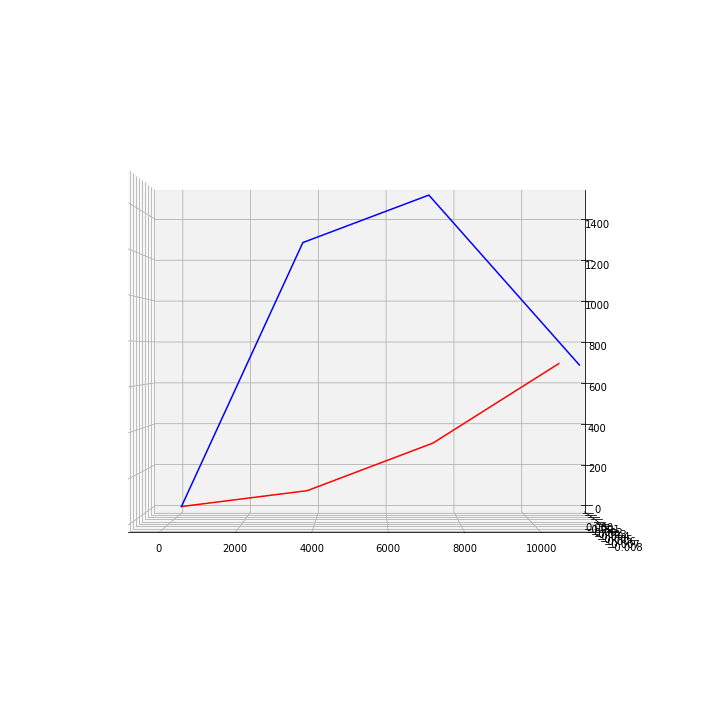

In [263]:
fig=plt.figure(figsize=(13,13))
ax = fig.gca(projection='3d')

X0=fin[0,[i for i in range(0,node_N)]]
Y0=fin[0,[i for i in range(2*node_N,3*node_N)]]
Z0=fin[0,[i for i in range(4*node_N,5*node_N)]]
# for j in range(len(fin.y.T)):
j=-1
X=fin[j,[i for i in range(0,node_N)]]
Y=fin[j,[i for i in range(2*node_N,3*node_N)]]
Z=fin[j,[i for i in range(4*node_N,5*node_N)]]

ax.plot(X0,Y0,Z0, color='r')
ax.plot(X,Y,Z, color='b') 
ax.view_init(-30,-30)
ax.view_init(0,-90)
# ax.view_init(-90,-90)
# ax.set_xlim([0, 5])
# ax.set_ylim([0, 5])
plt.show()

In [264]:
X,Y,Z

(array([    0.        ,  3561.5653526 ,  7245.79360369, 11052.697518  ]),
 array([ 0.00000000e+00, -2.24160774e-04, -9.76113434e-05, -7.84438800e-03]),
 array([   0.        , 1281.1952432 , 1512.53425584,  694.42184725]))

In [265]:
X0,Y0,Z0

(array([    0.        ,  3684.22828149,  7368.45656297, 11052.68484446]),
 array([0., 0., 0., 0.]),
 array([  0.        ,  77.06804645, 308.4070593 , 694.42189511]))

In [266]:
us=fin.T

In [267]:
# t=np.arange(tspan[0],tspan[1],tspan[1]/len(us.T))

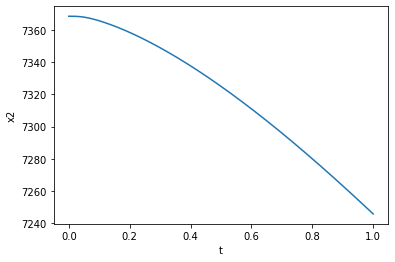

In [268]:
plt.plot(t,us.T[:,2],'-')
plt.xlabel('t')
plt.ylabel('x2')
plt.show()

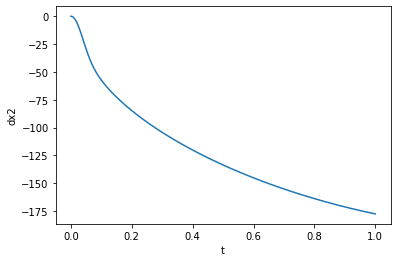

In [269]:
plt.plot(t,us.T[:,6] ,'-')
plt.xlabel('t')
plt.ylabel('dx2')
plt.show()

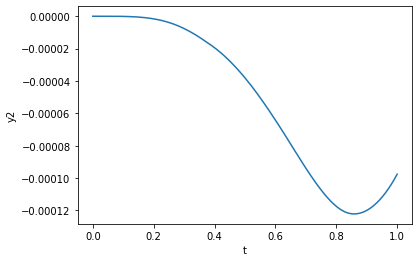

In [270]:
plt.plot(t,us.T[:,10] ,'-')
plt.xlabel('t')
plt.ylabel('y2')
plt.show()

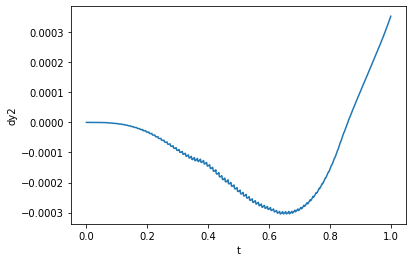

In [271]:
plt.plot(t,us.T[:,14] ,'-')
plt.xlabel('t')
plt.ylabel('dy2')
plt.show()

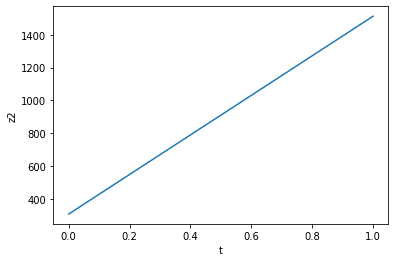

In [272]:
plt.plot(t,us.T[:,18] ,'-')
plt.xlabel('t')
plt.ylabel('z2')
plt.show()

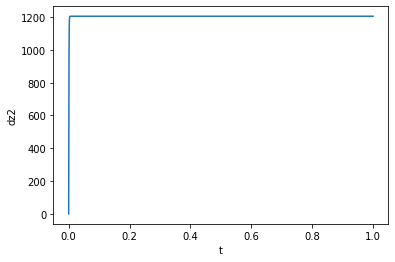

In [273]:
plt.plot(t,us.T[:,22] ,'-')
plt.xlabel('t')
plt.ylabel('dz2')
plt.show()

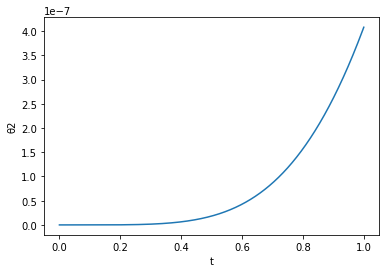

In [274]:
plt.plot(t,us.T[:,34],'-')
plt.xlabel('t')
plt.ylabel('θ2')
plt.show()

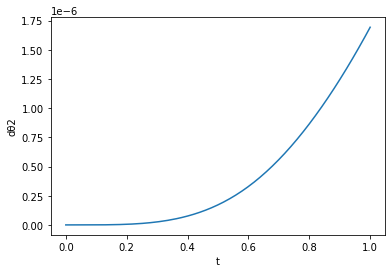

In [275]:
plt.plot(t,us.T[:,38] ,'-')
plt.xlabel('t')
plt.ylabel('dθ2')
plt.show()

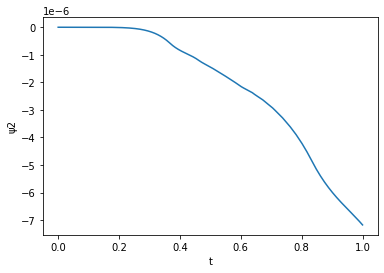

In [276]:
plt.plot(t,us.T[:,42],'-')
plt.xlabel('t')
plt.ylabel('ψ2')
plt.show()

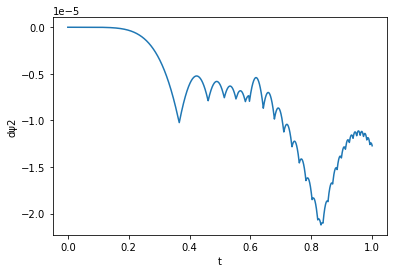

In [277]:
plt.plot(t,us.T[:,46] ,'-')
plt.xlabel('t')
plt.ylabel('dψ2')
plt.show()